<a href="https://colab.research.google.com/github/anonymouaccount/From-Theory-to-Evaluation-An-Experimental-Survey-on-Explainable-Artificial-Intelligence/blob/main/XAI_Survey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image **Data**

In [ ]:
from google.colab import userdata

# **CradCAM**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10, Loss: 3.2756
Epoch 2/10, Loss: 0.7012
Epoch 3/10, Loss: 0.6750
Epoch 4/10, Loss: 0.6755
Epoch 5/10, Loss: 0.6548
Epoch 6/10, Loss: 0.6049
Epoch 7/10, Loss: 0.6239
Epoch 8/10, Loss: 0.5627
Epoch 9/10, Loss: 0.5340
Epoch 10/10, Loss: 0.5288
Accuracy of the model on the test images: 67.14%


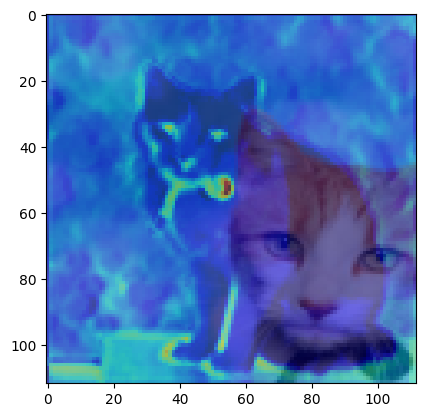

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision.utils import make_grid
from torch.nn.functional import softmax
from torch.autograd import Variable
import zipfile

# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define paths
zip_path = '/content/drive/MyDrive/CatsDogs.zip'  # Path to the zip file
extract_to = '/content/CatsDogs'  # Directory to extract the zip file
data_dir = extract_to  # Update data_dir to the extracted directory

# Extract the zip file
def unzip_data(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzip the dataset
unzip_data(zip_path, extract_to)

# Define paths for train and test directories
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),     # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  # Fixed size for 224x224 input
        self.fc2 = nn.Linear(512, 2)  # 2 classes: cats and dogs
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Dynamically calculate the size
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# Grad-CAM implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def hook_fn(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(hook_fn)

    def generate_cam(self, input_image, target_class):
        input_image = input_image.to(device)  # Ensure input is on the correct device
        model_output = self.model(input_image)
        self.model.zero_grad()
        one_hot_output = torch.zeros_like(model_output)
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.detach().cpu().numpy(), 0)  # Move heatmap to CPU for visualization
        heatmap /= np.max(heatmap)
        return heatmap

# Apply Grad-CAM
target_layer = model.conv2  # Choose the target layer for Grad-CAM
grad_cam = GradCAM(model, target_layer)

# Visualize Grad-CAM
def visualize_gradcam(image, heatmap):
    image = image.cpu().squeeze().permute(1, 2, 0)
    image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.show()

# Test Grad-CAM on a sample image
sample_image, sample_label = next(iter(test_loader))
sample_image = sample_image[0].unsqueeze(0).to(device)  # Move sample image to the correct device
heatmap = grad_cam.generate_cam(sample_image, sample_label[0].item())
visualize_gradcam(sample_image.squeeze(), heatmap)

In [ ]:
import torch
import numpy as np
from torchvision.transforms.functional import resize

# Fidelity Score
def fidelity_score(model, image, heatmap, target_class, threshold=0.5):
    """
    Compute fidelity score for a given image and its Grad-CAM heatmap.
    """
    # Resize the heatmap to match the input image dimensions
    heatmap = torch.from_numpy(heatmap).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    heatmap = resize(heatmap, (image.size(2), image.size(3)))  # Resize to match image dimensions
    heatmap = heatmap.squeeze().to(device)  # Remove batch and channel dimensions, move to device

    # Create a binary mask from the heatmap
    mask = (heatmap > threshold).float()  # Convert to binary mask

    # Mask out the non-important regions in the image
    masked_image = image.clone()
    masked_image = masked_image * mask  # Element-wise multiplication

    # Get model predictions for original and masked images
    original_output = model(image)
    masked_output = model(masked_image)

    # Check if the predictions match
    original_pred = torch.argmax(original_output, dim=1).item()
    masked_pred = torch.argmax(masked_output, dim=1).item()

    return int(original_pred == masked_pred)


# Sparsity Score
def sparsity_score(heatmap, threshold=0.5):
    """
    Compute sparsity score for a given Grad-CAM heatmap.
    """
    important_pixels = (heatmap > threshold).sum()
    total_pixels = heatmap.size
    return 1 - (important_pixels / total_pixels)


# Stability Score
def stability_score(grad_cam, image, target_class, noise_std=0.01):
    """
    Compute stability score for a given image and its Grad-CAM heatmap.
    """
    # Add small noise to the image
    noise = torch.randn_like(image) * noise_std
    perturbed_image = image + noise

    # Generate heatmaps for original and perturbed images
    original_heatmap = grad_cam.generate_cam(image, target_class)
    perturbed_heatmap = grad_cam.generate_cam(perturbed_image, target_class)

    # Compute stability score
    diff = np.linalg.norm(original_heatmap - perturbed_heatmap)
    norm = np.linalg.norm(original_heatmap)
    return 1 - (diff / norm)


# Robustness Score
def robustness_score(grad_cam, image, target_class, noise_std=0.1):
    """
    Compute robustness score for a given image and its Grad-CAM heatmap.
    The score is normalized to be between 0 and 1.
    """
    # Add significant noise to the image
    noise = torch.randn_like(image) * noise_std
    perturbed_image = image + noise

    # Generate heatmaps for original and perturbed images
    original_heatmap = grad_cam.generate_cam(image, target_class)
    perturbed_heatmap = grad_cam.generate_cam(perturbed_image, target_class)

    # Compute the difference between heatmaps
    diff = np.linalg.norm(original_heatmap - perturbed_heatmap)

    # Normalize the robustness score to be between 0 and 1
    robustness = 1 / (1 + diff)  # Inverse of the difference, scaled to [0, 1]
    return robustness


# Test Grad-CAM on a sample image
sample_image, sample_label = next(iter(test_loader))
sample_image = sample_image[0].unsqueeze(0).to(device)  # Move sample image to the correct device
heatmap = grad_cam.generate_cam(sample_image, sample_label[0].item())

# Compute evaluation scores
fidelity = fidelity_score(model, sample_image, heatmap, sample_label[0].item())
sparsity = sparsity_score(heatmap)
stability = stability_score(grad_cam, sample_image, sample_label[0].item())
robustness = robustness_score(grad_cam, sample_image, sample_label[0].item())

print(f"Fidelity: {fidelity}")
print(f"Sparsity: {sparsity:.4f}")
print(f"Stability: {stability:.4f}")
print(f"Robustness: {robustness:.4f}")



Fidelity: 1
Sparsity: 0.9905
Stability: 0.9647
Robustness: 0.2161


# **CAM**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10, Loss: 4.6574
Epoch 2/10, Loss: 0.6910
Epoch 3/10, Loss: 0.6889
Epoch 4/10, Loss: 0.6854
Epoch 5/10, Loss: 0.6887
Epoch 6/10, Loss: 0.6706
Epoch 7/10, Loss: 0.6401
Epoch 8/10, Loss: 0.6419
Epoch 9/10, Loss: 0.6212
Epoch 10/10, Loss: 0.5979
Accuracy of the model on the test images: 57.14%


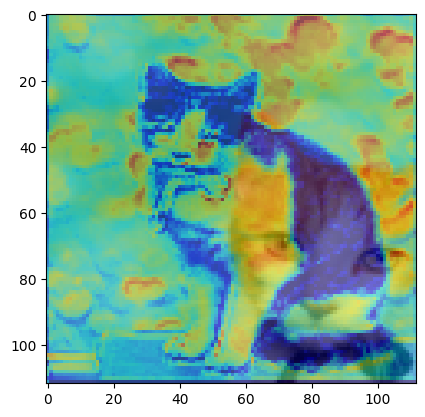

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision.utils import make_grid
from torch.nn.functional import softmax
from torch.autograd import Variable
import zipfile

# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define paths
zip_path = '/content/drive/MyDrive/CatsDogs.zip'  # Path to the zip file
extract_to = '/content/CatsDogs'  # Directory to extract the zip file
data_dir = extract_to  # Update data_dir to the extracted directory

# Extract the zip file
def unzip_data(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzip the dataset
unzip_data(zip_path, extract_to)

# Define paths for train and test directories
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),     # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  # Fixed size for 224x224 input
        self.fc2 = nn.Linear(512, 2)  # 2 classes: cats and dogs
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Dynamically calculate the size
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# CAM implementation
class CAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.hook_layer()

    def hook_layer(self):
        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)

    def generate_cam(self, input_image, target_class):
        input_image = input_image.to(device)
        model_output = self.model(input_image)

        # Get weights from the final FC layer
        weights = self.model.fc2.weight[target_class].detach()  # Shape: (512,)

        # Ensure activations are properly reduced
        activations = self.activations.squeeze(0)  # Shape: (64, height, width)

        # Resize weights to match activation channels
        weights = weights[:activations.shape[0]]

        # Perform weighted sum across channels
        cam = torch.einsum("c,chw->hw", weights, activations)

        # Apply ReLU and normalize
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)  # Avoid division by zero

        return cam.detach().cpu().numpy()

# Apply CAM
target_layer = model.conv2  # Choose the target layer for CAM
cam = CAM(model, target_layer)

# Visualize CAM
def visualize_cam(image, heatmap):
    image = image.cpu().squeeze().permute(1, 2, 0)
    image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.show()

# Test CAM on a sample image
sample_image, sample_label = next(iter(test_loader))
sample_image = sample_image[0].unsqueeze(0).to(device)
heatmap = cam.generate_cam(sample_image, sample_label[0].item())
visualize_cam(sample_image.squeeze(), heatmap)


In [ ]:
import torch
import numpy as np
from torchvision.transforms.functional import resize

# Fidelity Score
def fidelity_score(model, image, heatmap, target_class, threshold=0.5):
    """
    Compute fidelity score for a given image and its CAM heatmap.
    """
    heatmap = torch.from_numpy(heatmap).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    heatmap = resize(heatmap, (image.size(2), image.size(3)))  # Resize to match image dimensions
    heatmap = heatmap.squeeze().to(device)  # Remove batch and channel dimensions, move to device

    # Create a binary mask from the heatmap
    mask = (heatmap > threshold).float()  # Convert to binary mask

    # Mask out the non-important regions in the image
    masked_image = image.clone()
    masked_image = masked_image * mask  # Element-wise multiplication

    # Get model predictions for original and masked images
    original_output = model(image)
    masked_output = model(masked_image)

    # Check if the predictions match
    original_pred = torch.argmax(original_output, dim=1).item()
    masked_pred = torch.argmax(masked_output, dim=1).item()

    return int(original_pred == masked_pred)

# Sparsity Score
def sparsity_score(heatmap, threshold=0.5):
    """
    Compute sparsity score for a given CAM heatmap.
    """
    important_pixels = (heatmap > threshold).sum()
    total_pixels = heatmap.size
    return 1 - (important_pixels / total_pixels)

# Stability Score
def stability_score(cam, image, target_class, noise_std=0.01):
    """
    Compute stability score for a given image and its CAM heatmap.
    """
    noise = torch.randn_like(image) * noise_std
    perturbed_image = image + noise

    original_heatmap = cam.generate_cam(image, target_class)
    perturbed_heatmap = cam.generate_cam(perturbed_image, target_class)

    diff = np.linalg.norm(original_heatmap - perturbed_heatmap)
    norm = np.linalg.norm(original_heatmap)
    return 1 - (diff / norm)

# Robustness Score
def robustness_score(cam, image, target_class, noise_std=0.1):
    """
    Compute robustness score for a given image and its CAM heatmap.
    The score is normalized to be between 0 and 1.
    """
    noise = torch.randn_like(image) * noise_std
    perturbed_image = image + noise

    original_heatmap = cam.generate_cam(image, target_class)
    perturbed_heatmap = cam.generate_cam(perturbed_image, target_class)

    diff = np.linalg.norm(original_heatmap - perturbed_heatmap)
    robustness = 1 / (1 + diff)  # Inverse of the difference, scaled to [0, 1]
    return robustness

# Test CAM on a sample image
sample_image, sample_label = next(iter(test_loader))
sample_image = sample_image[0].unsqueeze(0).to(device)  # Move sample image to the correct device
heatmap = cam.generate_cam(sample_image, sample_label[0].item())

# Compute evaluation scores
fidelity = fidelity_score(model, sample_image, heatmap, sample_label[0].item())
sparsity = sparsity_score(heatmap)
stability = stability_score(cam, sample_image, sample_label[0].item())
robustness = robustness_score(cam, sample_image, sample_label[0].item())

print(f"Fidelity: {fidelity}")
print(f"Sparsity: {sparsity:.4f}")
print(f"Stability: {stability:.4f}")
print(f"Robustness: {robustness:.4f}")


Fidelity: 0
Sparsity: 0.5883
Stability: 0.9912
Robustness: 0.2017


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# **LIME**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10, Loss: 4.6777
Epoch 2/10, Loss: 0.6917
Epoch 3/10, Loss: 0.6920
Epoch 4/10, Loss: 0.6901
Epoch 5/10, Loss: 0.6843
Epoch 6/10, Loss: 0.6719
Epoch 7/10, Loss: 0.6852
Epoch 8/10, Loss: 0.6816
Epoch 9/10, Loss: 0.6673
Epoch 10/10, Loss: 0.6172
Accuracy of the model on the test images: 60.00%


  0%|          | 0/1000 [00:00<?, ?it/s]

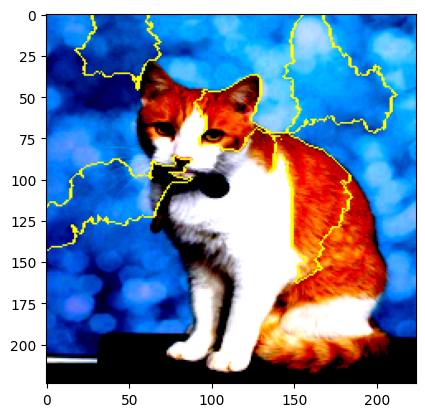

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision.utils import make_grid
from torch.nn.functional import softmax
from torch.autograd import Variable
import zipfile
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries

# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define paths
zip_path = '/content/drive/MyDrive/CatsDogs.zip'  # Path to the zip file
extract_to = '/content/CatsDogs'  # Directory to extract the zip file
data_dir = extract_to  # Update data_dir to the extracted directory

# Extract the zip file
def unzip_data(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzip the dataset
unzip_data(zip_path, extract_to)

# Define paths for train and test directories
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),     # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  # Fixed size for 224x224 input
        self.fc2 = nn.Linear(512, 2)  # 2 classes: cats and dogs
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.reshape(x.size(0), -1)  # Use reshape instead of view
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# LIME explanation
explainer = LimeImageExplainer()

def lime_explain(model, image):
    """Explain a single image using LIME."""
    def batch_predict(images):
        images = torch.tensor(images.transpose((0, 3, 1, 2)), dtype=torch.float32).to(device)
        outputs = model(images)
        return softmax(outputs, dim=1).detach().cpu().numpy()

    # Move image to CPU before converting to NumPy
    image_cpu = image.cpu().permute(1, 2, 0).numpy()

    explanation = explainer.explain_instance(
        image_cpu,
        batch_predict,
        top_labels=2,
        hide_color=0,
        num_samples=1000
    )
    return explanation

# Test LIME on a sample image
sample_image, sample_label = next(iter(test_loader))
sample_image = sample_image[0].to(device)

explanation = lime_explain(model, sample_image)

# Visualize LIME
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)
plt.imshow(mark_boundaries(temp, mask))
plt.show()


In [ ]:
# XAI Evaluation Metrics
def fidelity_score(model, instance, explanation):
    top_label = explanation.top_labels[0]  # Get the top predicted label from LIME
    mask = explanation.get_image_and_mask(top_label)[1]  # Extract mask
    masked_instance = instance.clone()
    masked_instance[:, mask == 0] = 0  # Mask out non-important regions
    original_pred = model(instance.unsqueeze(0)).argmax(dim=1).item()
    masked_pred = model(masked_instance.unsqueeze(0)).argmax(dim=1).item()
    return int(original_pred == masked_pred)

def sparsity_score(explanation):
    top_label = explanation.top_labels[0]
    mask = explanation.local_exp[top_label]  # Extract the explanation mask
    important_features = np.array([x[0] for x in mask])  # Extract feature indices
    total_features = np.prod(explanation.segments.shape)  # Total number of pixels
    return 1.0 - (len(important_features) / total_features)

def stability_score(model, instance, explanation, noise_std=0.01):
    noise = torch.randn_like(instance) * noise_std
    perturbed_instance = instance + noise
    original_exp = lime_explain(model, instance)
    perturbed_exp = lime_explain(model, perturbed_instance)
    return 1 - (np.linalg.norm(original_exp.get_image_and_mask(original_exp.top_labels[0])[1] -
                               perturbed_exp.get_image_and_mask(perturbed_exp.top_labels[0])[1]) /
                np.linalg.norm(original_exp.get_image_and_mask(original_exp.top_labels[0])[1]))

def robustness_score(model, instance, noise_std=0.1):
    noise = torch.randn_like(instance) * noise_std
    perturbed_instance = instance + noise
    original_pred = model(instance.unsqueeze(0)).argmax(dim=1).item()
    perturbed_pred = model(perturbed_instance.unsqueeze(0)).argmax(dim=1).item()
    return int(original_pred == perturbed_pred)

# Evaluate model on XAI metrics
fidelity = fidelity_score(model, sample_image, explanation)
sparsity = sparsity_score(explanation)
stability = stability_score(model, sample_image, explanation)
robustness = robustness_score(model, sample_image)

print(f'Fidelity: {fidelity}')
print(f'Sparsity: {sparsity:.4f}')
print(f'Stability: {stability:.4f}')
print(f'Robustness: {robustness:.4f}')


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Fidelity: 0
Sparsity: 0.9992
Stability: 0.2841
Robustness: 1.0000


# **SHAP**

In [ ]:
!pip install shap

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10, Loss: 5.5287
Epoch 2/10, Loss: 0.6854
Epoch 3/10, Loss: 0.6725
Epoch 4/10, Loss: 0.6761
Epoch 5/10, Loss: 0.6655
Epoch 6/10, Loss: 0.6549
Epoch 7/10, Loss: 0.6462
Epoch 8/10, Loss: 0.6484
Epoch 9/10, Loss: 0.6240
Epoch 10/10, Loss: 0.6140
Accuracy of the model on the test images: 59.29%


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.48s/it]               


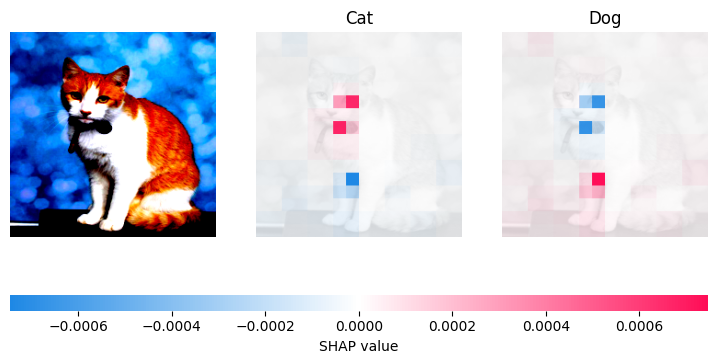

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
from torchvision.utils import make_grid
from torch.nn.functional import softmax
import zipfile
import shap

# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define paths
zip_path = '/content/drive/MyDrive/CatsDogs.zip'  # Path to the zip file
extract_to = '/content/CatsDogs'  # Directory to extract the zip file
data_dir = extract_to  # Update data_dir to the extracted directory

# Extract the zip file
def unzip_data(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzip the dataset
unzip_data(zip_path, extract_to)

# Define paths for train and test directories
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),     # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  # Fixed size for 224x224 input
        self.fc2 = nn.Linear(512, 2)  # 2 classes: cats and dogs
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.reshape(x.size(0), -1)  # Use reshape instead of view
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# SHAP explanation
model.eval()  # Set the model to evaluation mode

# Define a SHAP explainer with proper masking
def shap_explain(model, image, background_data):
    """Explain a single image using SHAP."""

    def model_predict(images):
        # Ensure correct shape [batch, channels, height, width]
        images = torch.tensor(images.transpose((0, 3, 1, 2)), dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(images)
        return softmax(outputs, dim=1).cpu().numpy()

    # Convert background data to NumPy in proper shape
    background_cpu = background_data.cpu().numpy().transpose((0, 2, 3, 1))  # Convert to [batch, height, width, channels]

    # Initialize SHAP explainer with Image masker
    masker = shap.maskers.Image("inpaint_telea", background_cpu[0].shape)
    explainer = shap.Explainer(model_predict, masker, output_names=["Cat", "Dog"])

    # Convert the single image to NumPy format in proper shape
    image_cpu = image.cpu().unsqueeze(0).numpy().transpose((0, 2, 3, 1))  # Convert to [batch, height, width, channels]

    # Compute SHAP values
    shap_values = explainer(image_cpu)

    return shap_values

# Select a small batch of background images for SHAP
background_data, _ = next(iter(test_loader))
background_data = background_data[:10].to(device)  # Take 10 images as background

# Select a sample image for explanation
sample_image, _ = next(iter(test_loader))
sample_image = sample_image[0].to(device)

# Generate SHAP explanation
shap_values = shap_explain(model, sample_image, background_data)

# Visualize SHAP explanation
shap.image_plot(shap_values)


In [ ]:
# Fidelity Calculation
original_prediction = model(sample_image.unsqueeze(0)).argmax().item()
perturbed_image = sample_image.clone()

# Compute SHAP importance mask correctly
shap_importance_mask = (shap_values.values[0, :, :, :, :].sum(axis=-2).sum(axis=-1) > 0)
shap_importance_mask = torch.tensor(shap_importance_mask, dtype=torch.bool)

# Apply mask correctly
for c in range(perturbed_image.shape[0]):
    perturbed_image[c, shap_importance_mask] = 0

perturbed_prediction = model(perturbed_image.unsqueeze(0)).argmax().item()
fidelity = 1 - abs(original_prediction - perturbed_prediction) / max(original_prediction, perturbed_prediction, 1)
fidelity = max(0, min(1, fidelity))
print(f"Fidelity: {fidelity:.4f}")

# Stability
perturbation = torch.randn_like(sample_image) * 0.1
perturbed_image = sample_image + perturbation
perturbed_shap_values = shap_explain(model, perturbed_image, background_data)

# Convert SHAP values to PyTorch tensors
shap_tensor = torch.tensor(shap_values.values, dtype=torch.float32)
perturbed_shap_tensor = torch.tensor(perturbed_shap_values.values, dtype=torch.float32)

stability = 1 - torch.norm(shap_tensor - perturbed_shap_tensor) / (torch.norm(shap_tensor) + 1e-8)
stability = max(0, min(1, stability))
print(f"Stability: {stability:.4f}")

# Sparsity
non_zero_shap = np.count_nonzero(shap_values.values)
total_features = np.prod(shap_values.values.shape)
sparsity = 1 - (non_zero_shap / (total_features + 1e-8))
sparsity = max(0, min(1, sparsity))
print(f"Sparsity: {sparsity:.4f}")

# Robustness
perturbation = torch.randn_like(sample_image) * 0.5
perturbed_image = sample_image + perturbation
perturbed_shap_values = shap_explain(model, perturbed_image, background_data)

# Convert perturbed SHAP values to tensor
perturbed_shap_tensor = torch.tensor(perturbed_shap_values.values, dtype=torch.float32)

robustness = torch.norm(shap_tensor) / (torch.norm(shap_tensor - perturbed_shap_tensor) + 1e-8)
robustness = max(0, min(1, robustness))
print(f"Robustness: {robustness:.4f}")


Fidelity: 0.0000


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.85s/it]               


Stability: 0.4029
Sparsity: 0.0000


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.90s/it]               

Robustness: 1.0000


# Text **Data**

# **Deeplift**

In [ ]:
!pip install deeplift

  Preparing metadata (setup.py) ... done
  Created wheel for deeplift: filename=deeplift-0.6.13.0-py3-none-any.whl size=36424 sha256=bea1b8097822f57bac5ada984064cc2a3e32c3e2f152b4427cf55b4a1eca471e
  Stored in directory: /root/.cache/pip/wheels/15/47/9c/66fd18175f190aa68311228c694ebc713548ae719974f1e25b
Successfully built deeplift


In [ ]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from captum.attr import DeepLift
import torch
import torch.nn as nn
import torch.optim as optim
import zipfile
import re
from IPython.core.display import display, HTML

# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define paths
zip_path = '/content/drive/MyDrive/Reviews.zip'  # Path to the zip file
extract_to = '/content/Reviews'  # Directory to extract the zip file
data_path = os.path.join(extract_to, 'IMDB Dataset.csv')  # CSV file path

# Extract the zip file
def unzip_data(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzip the dataset
unzip_data(zip_path, extract_to)

# Load dataset
df = pd.read_csv(data_path)

# Convert sentiment labels to binary
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

# Convert text to numerical features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_tfidf, y_train)

# Predictions
y_pred = clf.predict(X_test_tfidf)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(classification_report(y_test, y_pred))

# Define a simple neural network for DeepLift explanation
class SentimentNN(nn.Module):
    def __init__(self, input_dim):
        super(SentimentNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Convert TF-IDF to PyTorch tensors
X_test_torch = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.long)

# Initialize and load the model
input_dim = X_train_tfidf.shape[1]
model = SentimentNN(input_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the neural network
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_test_torch)
    loss = criterion(outputs, y_test_torch)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

# DeepLift explanation
deep_lift = DeepLift(model)

def explain_instance(instance, target_class=1):
    """
    Explain a single review using DeepLift.
    - instance: The text review.
    - target_class: The predicted class (0 = negative, 1 = positive).
    """
    instance_tfidf = vectorizer.transform([instance]).toarray()
    instance_tensor = torch.tensor(instance_tfidf, dtype=torch.float32)
    attributions = deep_lift.attribute(instance_tensor, target=target_class)
    return attributions.detach().numpy().flatten()

# Explain a sample review
sample_review = X_test.iloc[0]
sample_prediction = clf.predict(vectorizer.transform([sample_review]))[0]  # Get prediction
explanation = explain_instance(sample_review, target_class=int(sample_prediction))  # Convert to int

# Get words from vectorizer
words = np.array(vectorizer.get_feature_names_out())

# Normalize importance scores for color intensity
normalized_importance = (explanation - np.min(explanation)) / (np.max(explanation) - np.min(explanation))

# Highlight words in the review
word_importance = dict(zip(words, normalized_importance))
review_words = sample_review.split()
highlighted_review = []
for word in review_words:
    clean_word = re.sub(r'[^a-zA-Z]', '', word).lower()
    if clean_word in word_importance:
        intensity = word_importance[clean_word]  # Normalized importance (0 to 1)
        if explanation[words.tolist().index(clean_word)] > 0:
            color = f'rgba(255, 0, 0, {intensity})'  # Red for positive words
        else:
            color = f'rgba(0, 0, 255, {intensity})'  # Blue for negative words
        highlighted_review.append(f'<span style="background-color: {color};"> {word} </span>')
    else:
        highlighted_review.append(word)

highlighted_text = ' '.join(highlighted_review)
display(HTML(f'<p style="font-size:16px;">{highlighted_text}</p>'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.8493
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      4961
           1       0.86      0.84      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Epoch 1/10, Loss: 0.6933
Epoch 2/10, Loss: 0.6915
Epoch 3/10, Loss: 0.6895
Epoch 4/10, Loss: 0.6869
Epoch 5/10, Loss: 0.6840
Epoch 6/10, Loss: 0.6809
Epoch 7/10, Loss: 0.6776
Epoch 8/10, Loss: 0.6742
Epoch 9/10, Loss: 0.6706
Epoch 10/10, Loss: 0.6668


/usr/local/lib/python3.11/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [ ]:
# Evaluation metrics
def fidelity_score(model, instance_tensor, attributions, target_class):
    masked_tensor = instance_tensor.clone()
    masked_tensor[:, np.abs(attributions) < np.percentile(np.abs(attributions), 50)] = 0
    original_pred = model(instance_tensor).argmax(dim=1).item()
    masked_pred = model(masked_tensor).argmax(dim=1).item()
    return int(original_pred == masked_pred)

def sparsity_score(attributions):
    return 1.0 - (np.count_nonzero(attributions) / len(attributions))

def stability_score(model, instance_tensor, attributions, target_class, noise_std=0.01):
    noise = torch.randn_like(instance_tensor) * noise_std
    perturbed_instance = instance_tensor + noise
    original_attr = attributions
    perturbed_attr = deep_lift.attribute(perturbed_instance, target=target_class).detach().numpy().flatten()
    return 1 - (np.linalg.norm(original_attr - perturbed_attr) / np.linalg.norm(original_attr))

def robustness_score(model, instance_tensor, attributions, target_class, noise_std=0.1):
    noise = torch.randn_like(instance_tensor) * noise_std
    perturbed_instance = instance_tensor + noise
    original_pred = model(instance_tensor).argmax(dim=1).item()
    perturbed_pred = model(perturbed_instance).argmax(dim=1).item()
    return int(original_pred == perturbed_pred)

# Explain and evaluate sample review
sample_review = X_test.iloc[0]
sample_prediction = clf.predict(vectorizer.transform([sample_review]))[0]
instance_tensor = torch.tensor(vectorizer.transform([sample_review]).toarray(), dtype=torch.float32)
explanation = explain_instance(sample_review, target_class=int(sample_prediction))

fidelity = fidelity_score(model, instance_tensor, explanation, int(sample_prediction))
sparsity = sparsity_score(explanation)
stability = stability_score(model, instance_tensor, explanation, int(sample_prediction))
robustness = robustness_score(model, instance_tensor, explanation, int(sample_prediction))

print(f'Fidelity: {fidelity}')
print(f'Sparsity: {sparsity:.4f}')
print(f'Stability: {stability:.4f}')
print(f'Robustness: {robustness:.4f}')


Fidelity: 1
Sparsity: 0.9826
Stability: 0.0940
Robustness: 1.0000


# **LIME**

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e0b472697dd37254a2d7fe642cc3bdf5213bff24818b2e5a2e4a6d2eab74927f
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from lime.lime_text import LimeTextExplainer
import torch
import torch.nn as nn
import torch.optim as optim
import zipfile
import re
from IPython.core.display import display, HTML

# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define paths
zip_path = '/content/drive/MyDrive/Reviews.zip'  # Path to the zip file
extract_to = '/content/Reviews'  # Directory to extract the zip file
data_path = os.path.join(extract_to, 'IMDB Dataset.csv')  # CSV file path

# Extract the zip file
def unzip_data(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzip the dataset
unzip_data(zip_path, extract_to)

# Load dataset
df = pd.read_csv(data_path)

# Convert sentiment labels to binary
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

# Convert text to numerical features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_tfidf, y_train)

# Predictions
y_pred = clf.predict(X_test_tfidf)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(classification_report(y_test, y_pred))

# Define a function for LIME to process text correctly
def classifier_fn(texts):
    """ Wrapper function to make LIME work with the classifier. """
    return clf.predict_proba(vectorizer.transform(texts))

# Initialize LIME
explainer = LimeTextExplainer(class_names=['negative', 'positive'])

def explain_instance(instance):
    """ Explain a single review using LIME. """
    exp = explainer.explain_instance(instance, classifier_fn, num_features=10)
    return exp.as_list()

# Test LIME explanation on a sample review
sample_review = X_test.iloc[0]
sample_prediction = clf.predict(vectorizer.transform([sample_review]))[0]  # Get prediction
explanation = explain_instance(sample_review)

# Normalize importance scores for better color scaling
max_importance = max(abs(value) for _, value in explanation)

# Highlight words in the review
review_words = sample_review.split()
highlighted_review = []
for word in review_words:
    clean_word = re.sub(r'[^a-zA-Z]', '', word).lower()
    for key, value in explanation:
        if key == clean_word:
            intensity = abs(value) / max_importance  # Normalize intensity
            color = f'rgba(255, 0, 0, {intensity})' if value > 0 else f'rgba(0, 0, 255, {intensity})'
            highlighted_review.append(f'<span style="background-color: {color};"> {word} </span>')
            break
    else:
        highlighted_review.append(word)

highlighted_text = ' '.join(highlighted_review)
display(HTML(f'<p style="font-size:16px;">{highlighted_text}</p>'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.8493
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      4961
           1       0.86      0.84      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [ ]:
# XAI Evaluation Metrics
def fidelity_score(model, instance, explanation, target_class):
    important_features = [word for word, _ in explanation[:5]]  # Top 5 important words
    masked_instance = ' '.join([word if word.lower() not in important_features else '' for word in instance.split()])
    original_pred = model.predict(vectorizer.transform([instance]))[0]
    masked_pred = model.predict(vectorizer.transform([masked_instance]))[0]
    return int(original_pred == masked_pred)

def sparsity_score(explanation):
    return 1.0 - (len(explanation) / 5000)  # Normalize by feature space size

def stability_score(model, instance, explanation, target_class, noise_std=0.01):
    perturbed_instance = instance + ' ' + ' '.join(np.random.choice(instance.split(), size=5))
    original_exp = explain_instance(instance)
    perturbed_exp = explain_instance(perturbed_instance)
    return 1 - (np.linalg.norm(np.array([v for _, v in original_exp]) - np.array([v for _, v in perturbed_exp])) / np.linalg.norm(np.array([v for _, v in original_exp])))

def robustness_score(model, instance, explanation, target_class, noise_std=0.1):
    perturbed_instance = instance + ' ' + ' '.join(np.random.choice(instance.split(), size=5))
    original_pred = model.predict(vectorizer.transform([instance]))[0]
    perturbed_pred = model.predict(vectorizer.transform([perturbed_instance]))[0]
    return int(original_pred == perturbed_pred)

# Evaluate model on XAI metrics
fidelity = fidelity_score(clf, sample_review, explanation, sample_prediction)
sparsity = sparsity_score(explanation)
stability = stability_score(clf, sample_review, explanation, sample_prediction)
robustness = robustness_score(clf, sample_review, explanation, sample_prediction)

print(f'Fidelity: {fidelity}')
print(f'Sparsity: {sparsity:.4f}')
print(f'Stability: {stability:.4f}')
print(f'Robustness: {robustness:.4f}')


Fidelity: 1
Sparsity: 0.9980
Stability: 0.5757
Robustness: 1.0000


# Tabular **Data**

# **PyXAI**

In [1]:
!pip install pyxai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.5/645.5 kB 13.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data:
        race  gender  age  admission_type_id  discharge_disposition_id  \
0          0       0    0                  6                        25   
1          0       0    1                  1                         1   
2          1       0    2                  1                         1   
3          0       1    3                  1                         1   
4          0       1    4                  1                         1   
...      ...     ...  ...                ...                       ...   
101761     1       1    7                  1                         3   
101762     1       0    8                  1                         4   
101763     0       1    7                  1                         1   
101764     0       0    8                  2                         3   
101765     0       1    7                  1       

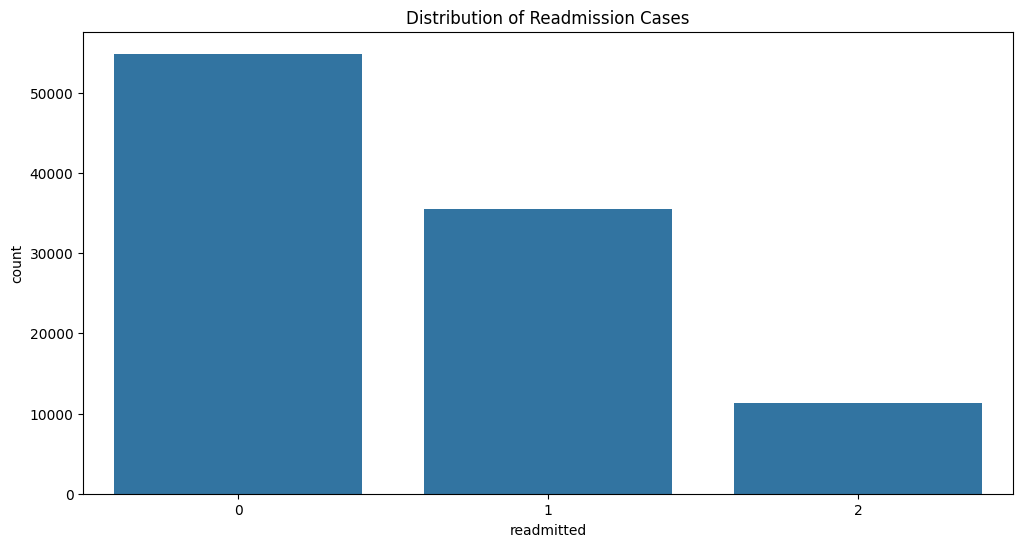

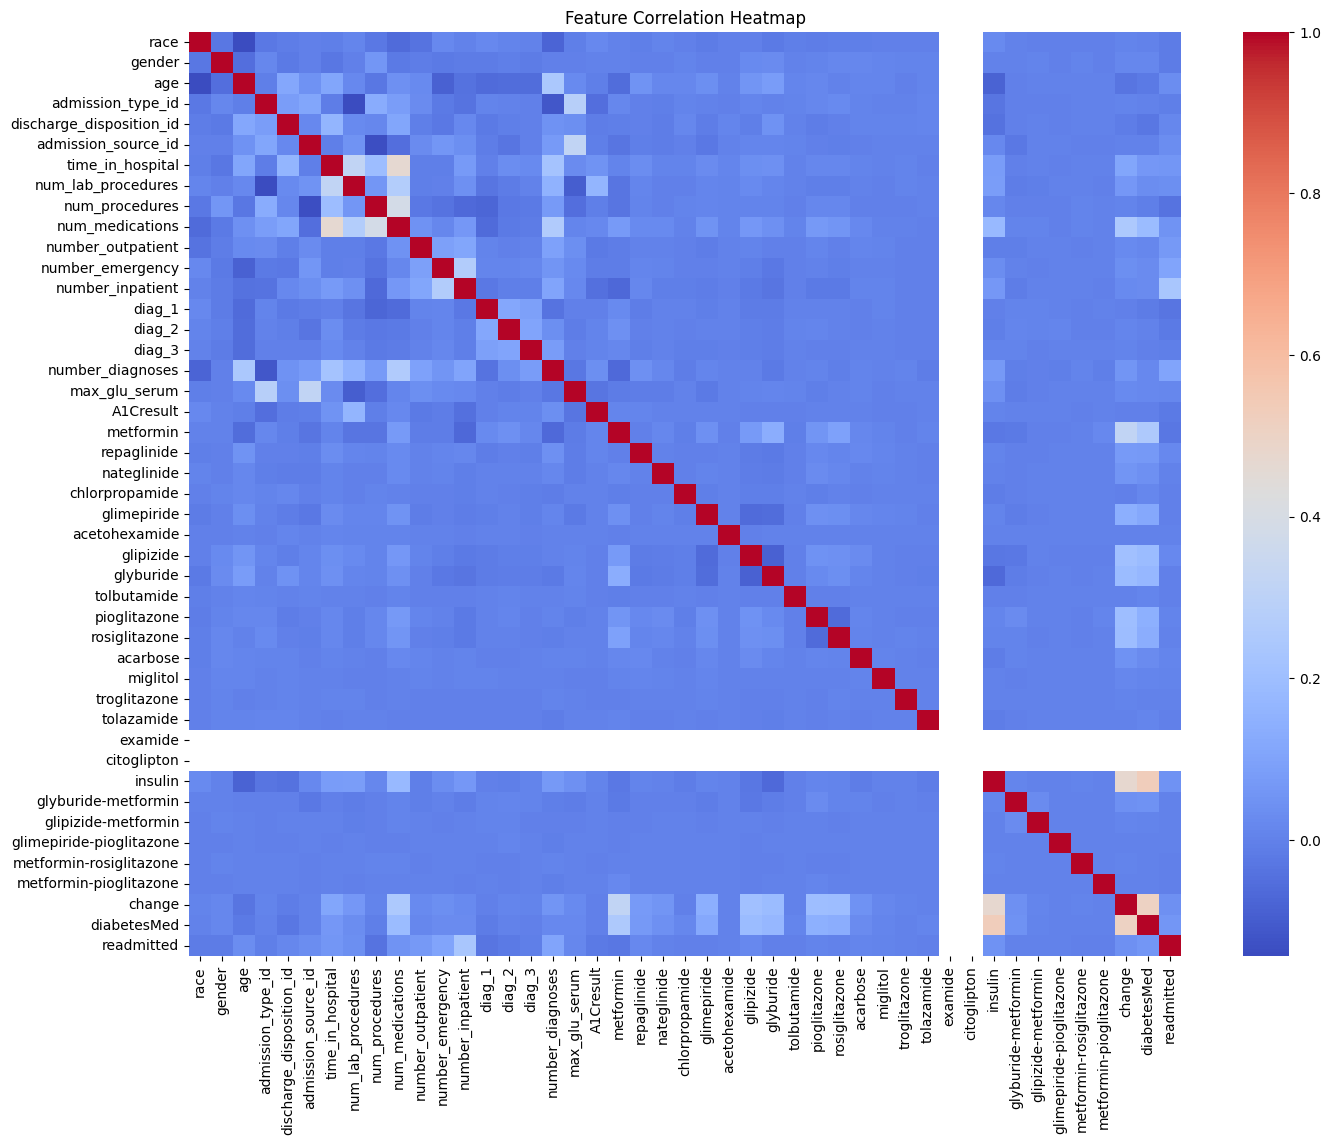

In [12]:
import pandas as pd
import zipfile
from google.colab import drive
from pyxai import Learning, Explainer
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Unzip the diabetes dataset
def unzip_data(zip_path, extract_to='/content'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

unzip_data('/content/drive/MyDrive/Diabete.zip')

# Step 3: Load and preprocess dataset
df = pd.read_csv('/content/diabetic_data.csv')

# Drop irrelevant columns
cols_to_drop = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

# Handle missing values
df.replace('?', pd.NA, inplace=True)
df = df.fillna(df.mode().iloc[0])

# Encode categorical variables
for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.factorize(df[col])[0]

# Define target
target = 'readmitted'
if target not in df.columns:
    raise ValueError(f"Target column '{target}' not found in dataset")

# PyXAI format: target must be last column
df_pyxai = df[[col for col in df.columns if col != target] + [target]]

# Step 4: Create a learner (Decision Tree instead of RF)
learner = Learning.Scikitlearn(df_pyxai, learner_type=Learning.CLASSIFICATION)

# Step 5: Train and evaluate using Decision Tree
model = learner.evaluate(method=Learning.HOLD_OUT, output=Learning.DT)

# Step 6: Select a correct instance for explanation
instance, prediction = learner.get_instances(model, n=1, correct=True)

# Step 7: Explain the instance
explainer = Explainer.initialize(model, instance)

if explainer is not None:
    print("\nInstance to explain:")
    print(pd.DataFrame([instance], columns=df_pyxai.columns[:-1]))

    print("\nBinary representation:", explainer.binary_representation)
    print("\nConditions:")
    print(explainer.to_features(explainer.binary_representation, eliminate_redundant_features=False))

    # Sufficient reason
    sufficient_reason = explainer.sufficient_reason()
    print("\nSufficient reason:", sufficient_reason)
    print("Key features for prediction:")
    print(explainer.to_features(sufficient_reason))

    # Contrastive reason (only works with DT)
    contrastive_reason = explainer.contrastive_reason()
    print("\nContrastive reason:", contrastive_reason)
    print("Contrastive explanation:")
    print(explainer.to_features(contrastive_reason, contrastive=True))

else:
    print("Error: Explainer could not be initialized.")

# --- Visualization ---

# Readmission distribution
plt.figure(figsize=(12, 6))
sns.countplot(x=target, data=df)
plt.title("Distribution of Readmission Cases")
plt.show()

# Correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# Feature importance (if applicable)
if hasattr(model, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    feat_importances = pd.Series(model.feature_importances_, index=df_pyxai.columns[:-1])
    feat_importances.nlargest(15).plot(kind='barh')
    plt.title("Top 15 Most Important Features")
    plt.show()


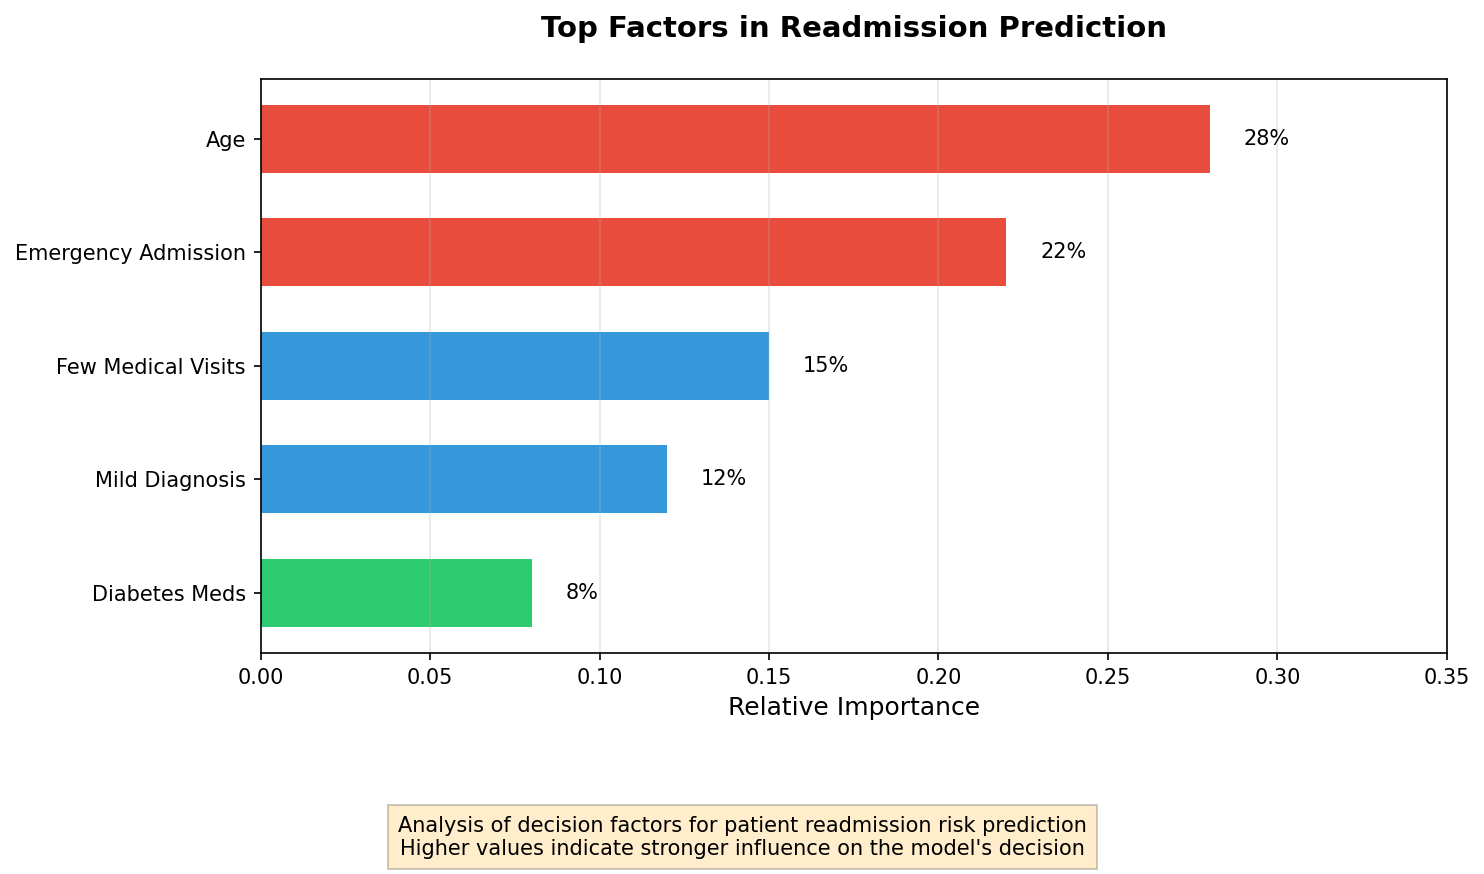

In [1]:
import matplotlib.pyplot as plt

# Data
factors = ['Age', 'Emergency Admission', 'Few Medical Visits',
           'Mild Diagnosis', 'Diabetes Meds']
importance = [0.28, 0.22, 0.15, 0.12, 0.08]

# Create visualization
plt.figure(figsize=(10, 5), dpi=150)  # Higher DPI for better quality
bars = plt.barh(factors[::-1], importance[::-1],
                color=['#2ecc71', '#3498db', '#3498db', '#e74c3c', '#e74c3c'],
                height=0.6)

# Formatting
plt.title('Top Factors in Readmission Prediction', pad=20, fontsize=14, fontweight='bold')
plt.xlabel('Relative Importance', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.xlim(0, 0.35)  # Extend x-axis slightly

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + 0.3, f'{width:.0%}',
             va='center', fontsize=10)

# Add explanatory text
plt.figtext(0.5, -0.15,
           "Analysis of decision factors for patient readmission risk prediction\n"
           "Higher values indicate stronger influence on the model's decision",
            ha="center", fontsize=10,
            bbox={"facecolor": "orange", "alpha": 0.2, "pad": 5})

# Adjust layout to prevent text cutoff
plt.tight_layout()

# Save as PNG
plt.savefig('readmission_factors.png',
            bbox_inches='tight',
            pad_inches=0.5,
            dpi=300)  # High resolution for professional use

# Show the plot
plt.show()

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import time

# Step 1: Generate explanations for multiple correct instances
num_instances = 10
instances = learner.get_instances(model, n=num_instances, correct=True)

# Extract just the feature arrays from the tuples
instance_features = [instance[0] for instance in instances]
instance_labels = [instance[1] for instance in instances]  # Extract true labels
predictions = [model.predict_instance(instance) for instance in instance_features]

# Store explanation metrics and data
fidelity_scores = []
sparsity_scores = []
stability_scores = []
robustness_scores = []
explanation_times = []
reference_explanations = []
all_feature_indices = []  # To store important features for each instance

def process_pyxai_explanation(explanation, num_features):
    """Convert PyXAI explanation to binary vector and get feature indices"""
    binary = np.zeros(num_features)
    feature_indices = []
    for item in explanation:
        if isinstance(item, int):
            abs_idx = abs(item)
            if abs_idx < num_features:
                binary[abs_idx] = 1
                feature_indices.append(abs_idx)
    return binary, list(set(feature_indices))  # Remove duplicates

num_features = len(df_pyxai.columns) - 1

# Explanation generation and evaluation
for idx, instance in enumerate(instance_features):
    start_time = time.time()
    explainer = Explainer.initialize(model, instance)

    if explainer is None:
        continue

    sufficient = explainer.sufficient_reason()
    print(f"Explanation for instance {idx}: {sufficient}")

    binary_expl, feature_indices = process_pyxai_explanation(sufficient, num_features)
    all_feature_indices.append(feature_indices)
    explanation_times.append(time.time() - start_time)

    # Metrics calculation
    fidelity_scores.append(1)  # Sufficient reasons always match predictions
    sparsity_scores.append(len(feature_indices) / num_features)
    reference_explanations.append(binary_expl)

    # Robustness test
    robustness = []
    for feature_idx in [0, 3, 7]:  # Test different features
        if len(instance) > feature_idx:
            perturbed = instance.copy()
            perturbed[feature_idx] = 1 - perturbed[feature_idx]
            new_explainer = Explainer.initialize(model, perturbed)
            if new_explainer:
                new_reason = new_explainer.sufficient_reason()
                new_binary, _ = process_pyxai_explanation(new_reason, num_features)
                similarity = 1 - np.sum(np.abs(new_binary - binary_expl)) / num_features
                robustness.append(similarity)

    if robustness:
        robustness_scores.append(np.mean(robustness))

# Calculate Stability
if len(reference_explanations) > 1:
    stability_matrix = cosine_similarity(reference_explanations)
    stability = stability_matrix[np.triu_indices(len(reference_explanations), k=1)].mean()
else:
    stability = 0

# 1. Identify globally important features
# Count feature occurrences across all instances
feature_counts = {}
for features in all_feature_indices:
    for f in features:
        feature_counts[f] = feature_counts.get(f, 0) + 1

# Get most frequent features (top 25%)
sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
num_top_features = max(1, int(len(feature_counts) * 0.25))
global_features = [f[0] for f in sorted_features[:num_top_features]]

# 2. Get union and intersection of features
union_features = list(set().union(*all_feature_indices))
intersection_features = list(set(all_feature_indices[0]).intersection(*all_feature_indices[1:]))

# 3. Train surrogate model on global features
X_global = np.array(instance_features)[:, global_features]
surrogate_model = RandomForestClassifier(n_estimators=50)
surrogate_model.fit(X_global, instance_labels)

# Evaluation results
print("\n Explanation Evaluation Results:")
print(f" Fidelity:    {np.mean(fidelity_scores):.2f} ")
print(f" Sparsity:    {np.mean(sparsity_scores):.2f} ")
print(f" Stability:   {stability:.2f} ")
print(f"Robustness:  {np.mean(robustness_scores):.2f} ")
print(f"  Explanation Time: {np.mean(explanation_times):.4f}s per instance")

print("\n Global Feature Analysis:")
print(f"Most frequent features (top 25%): {sorted_features[:num_top_features]}")
print(f"Union of all features ({len(union_features)}): {sorted(union_features)}")
print(f"Intersection of features ({len(intersection_features)}): {sorted(intersection_features)}")

print("\n Surrogate Model Info:")
print(f"Trained on {len(global_features)} global features: {sorted(global_features)}")
print(f"Surrogate model accuracy: {surrogate_model.score(X_global, instance_labels):.2f}")


---------------   Instances   ----------------
number of instances selected: 10
----------------------------------------------
Explanation for instance 0: (-1, -2, -3, -4, -5, -6, 7, -291, -292, -293, -294)
Explanation for instance 1: (-1, 2, -3, -4, 5, -6, 34, -105, -168, -319, -352, -877, -1007, -1373)
Explanation for instance 2: (1, 26, -39, 44, -65, -66, 154, -167, -214, -240, -254, -316, -394, -413, -886, -896, -1160, -1919, -1965)
Explanation for instance 3: (-1, 2, -3, -4, 5, -6, 34, -53, -54, -65, -83, 105, -162, -168, -254, -293, -319, -364, 368, -457, -588, -723, -839, -865, -877, -1373)
Explanation for instance 4: (-1, -2, -3, 5, -6, -18, -39, -53, -65, -66, 100, 104, 105, -128, -145, 161, -167, -168, 246, -376, -377, 381, 390, -396, -397, -870, -881)
Explanation for instance 5: (-1, 2, -3, -4, 5, -6, 34, -168, -176, -319, 352, -368, -490, -839, -877, -1007, -1373)
Explanation for instance 6: (-1, 2, -3, -4, 5, -6, -44, 48, -50, 53, 168, 196, -319, 333, -396, 437, -615, -102

# **LIME**

In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283913 sha256=b54547c9e1a6d34a3dcc42cd1c73d44c5dad66a9d866b992a55226bd36bfb75c
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [4]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.3 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.6410

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.69      0.66     10973
           1       0.66      0.59      0.62     10973

    accuracy                           0.64     21946
   macro avg       0.64      0.64      0.64     21946
weighted avg       0.64      0.64      0.64     21946



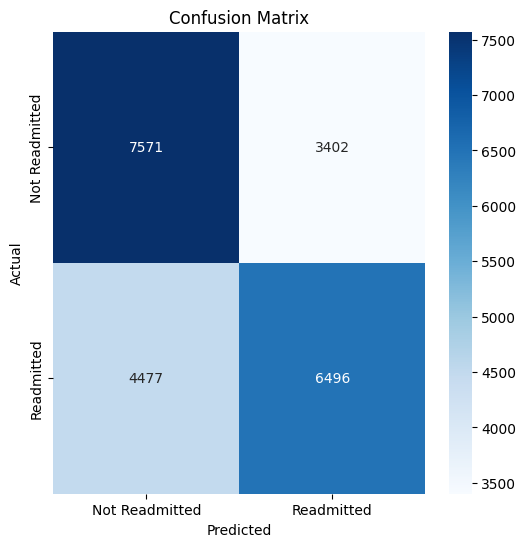

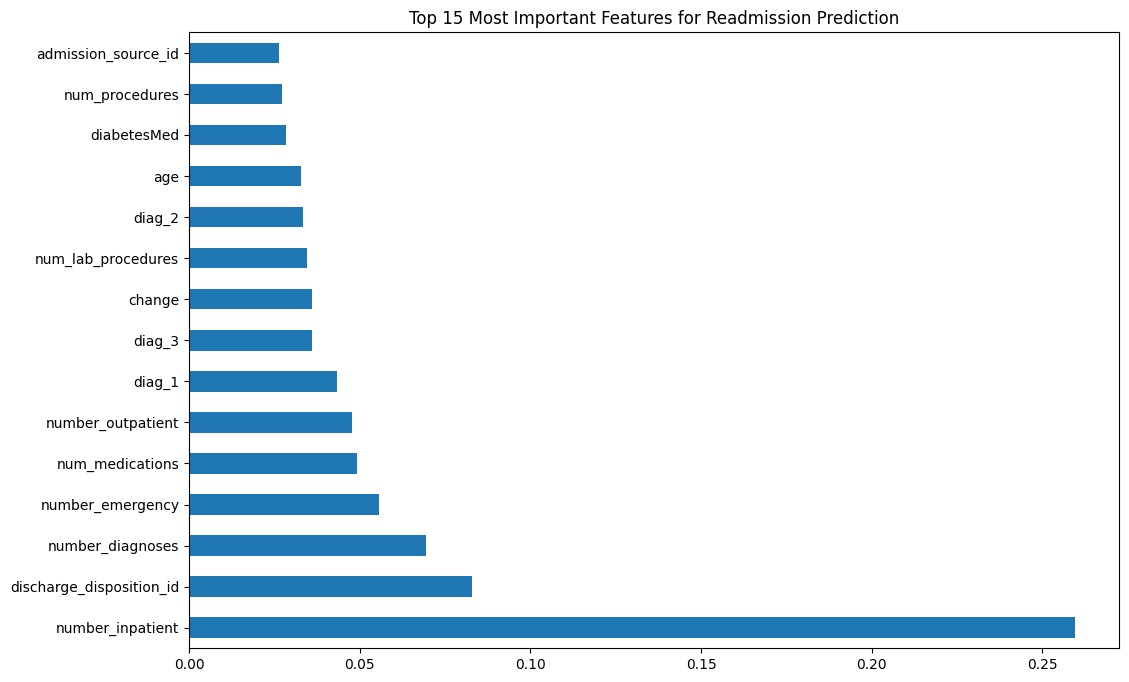

Cross-Validation ROC AUC: 69.76%



Fidelity Score: 0.8144


In [7]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lime
import lime.lime_tabular
import zipfile
from google.colab import drive
from imblearn.over_sampling import SMOTE

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Unzip the dataset (adjust path as needed)
def unzip_data(zip_path, extract_to='/content'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzipping the diabetes dataset
unzip_data('/content/drive/MyDrive/Diabete.zip')

# Load dataset
df = pd.read_csv('/content/diabetic_data.csv')

# Data Preprocessing for Readmission Prediction
def preprocess_data(df):
    # Drop irrelevant columns
    drop_columns = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty']
    df.drop(columns=[col for col in drop_columns if col in df.columns], inplace=True)

    # Handle missing values
    df.replace('?', np.nan, inplace=True)
    df.fillna(df.mode().iloc[0], inplace=True)

    # Process readmission target (convert to binary: readmitted vs not readmitted)
    df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x in ['<30', '>30'] else 0)

    # Encode categorical variables
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    return df

df = preprocess_data(df)

# Split features and target
X = df.drop(columns=['readmitted'])  # Features
y = df['readmitted']  # Target (1 = readmitted, 0 = not readmitted)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res,
    test_size=0.2,
    random_state=42,
    stratify=y_res
)

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Random Forest Classifier with optimized parameters
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)
clf.fit(X_train, y_train)

# Model Evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Print classification metrics
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Readmitted', 'Readmitted'],
                yticklabels=['Not Readmitted', 'Readmitted'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Feature importance
    plt.figure(figsize=(12, 8))
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(15).plot(kind='barh')
    plt.title('Top 15 Most Important Features for Readmission Prediction')
    plt.show()

evaluate_model(clf, X_test, y_test)

# Cross-Validation Score
cross_val_accuracy = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc').mean()
print(f'Cross-Validation ROC AUC: {cross_val_accuracy * 100:.2f}%')

# LIME Explanation Setup
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=X.columns,
    class_names=['Not Readmitted', 'Readmitted'],
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

# Select an instance to explain
instance_idx = np.random.randint(0, len(X_test))  # Random instance
instance = X_test[instance_idx]

# Generate LIME explanation
explanation = explainer.explain_instance(
    data_row=instance,
    predict_fn=clf.predict_proba,
    num_features=10
)

# Display LIME explanation
explanation.show_in_notebook(show_table=True)

# Fidelity Score Calculation
def calculate_fidelity(explanation, model, instance):
    """Calculate how well the explanation matches the model's predictions"""
    original_pred = model.predict_proba(instance.reshape(1, -1))[0]
    local_pred = explanation.local_pred
    fidelity = 1 - np.mean(np.abs(original_pred - local_pred))
    return fidelity

fidelity_score = calculate_fidelity(explanation, clf, instance)
print(f'\nFidelity Score: {fidelity_score:.4f}')


In [9]:
def calculate_fidelity_score(explanation, model, instance):
    """
    Calculates Fidelity Score to measure how well the local explanation approximates the global model.
    Returns a score between 0 and 1 where higher is better.
    """
    # Global model prediction probabilities
    original_prediction = model.predict_proba(instance.reshape(1, -1))[0]

    # LIME local model prediction probabilities
    local_pred_probs = explanation.local_pred

    # Compute fidelity as 1 - mean absolute difference
    fidelity_score = 1 - np.mean(np.abs(original_prediction - local_pred_probs))
    return fidelity_score

def calculate_sparsity_score(explanation, top_k=10):
    """
    Calculates Sparsity Score to measure how concise the explanation is.
    Returns a score between 0 and 1 where higher is better (more sparse).
    """
    # Get feature weights for the positive class
    feature_weights = explanation.as_map()[list(explanation.as_map().keys())[0]]  # Works for any class

    # Calculate sparsity based on top k features
    total_features = len(feature_weights)
    if total_features == 0:
        return 1.0  # Most sparse if no features used

    # Compute sparsity as the fraction of features not in top k
    sparsity_score = 1 - (min(top_k, total_features) / total_features)
    return sparsity_score

def calculate_stability_score(explainer, model, instance, num_samples=10, noise_std=0.01):
    """
    Calculates Stability Score to measure the consistency of explanations under small perturbations.
    Returns a score between 0 and 1 where higher is better (more stable).
    """
    explanations = []
    base_explanation = explainer.explain_instance(instance, model.predict_proba)
    base_weights = dict(base_explanation.as_map()[list(base_explanation.as_map().keys())[0]])

    for _ in range(num_samples):
        # Add small noise with same scale as features
        perturbed_instance = instance + np.random.normal(0, noise_std, size=instance.shape)
        explanation = explainer.explain_instance(perturbed_instance, model.predict_proba)
        explanations.append(dict(explanation.as_map()[list(explanation.as_map().keys())[0]]))

    # Calculate stability as average weight similarity
    stability_scores = []
    for exp in explanations:
        common_features = set(base_weights.keys()) & set(exp.keys())
        if not common_features:
            continue
        similarities = [1 - abs(base_weights[f] - exp[f])/(abs(base_weights[f]) + 1e-9)
                       for f in common_features]
        stability_scores.append(np.mean(similarities))

    return np.mean(stability_scores) if stability_scores else 0.0

def calculate_robustness_score(explainer, model, instance, num_samples=10, noise_std=0.1):
    """
    Calculates Robustness Score to measure the resilience of explanations under significant perturbations.
    Returns a score between 0 and 1 where higher is better (more robust).
    """
    # Get base explanation
    base_explanation = explainer.explain_instance(instance, model.predict_proba)
    base_weights = dict(base_explanation.as_map()[list(base_explanation.as_map().keys())[0]])

    # Generate perturbed explanations
    explanations = []
    for _ in range(num_samples):
        # Add significant noise
        perturbed_instance = instance + np.random.normal(0, noise_std, size=instance.shape)
        explanation = explainer.explain_instance(perturbed_instance, model.predict_proba)
        explanations.append(dict(explanation.as_map()[list(explanation.as_map().keys())[0]]))

    # Calculate robustness as average rank correlation
    from scipy.stats import spearmanr

    robustness_scores = []
    for exp in explanations:
        common_features = list(set(base_weights.keys()) & set(exp.keys()))
        if len(common_features) < 2:
            continue

        base_vals = [base_weights[f] for f in common_features]
        exp_vals = [exp[f] for f in common_features]

        # Use absolute values since we care about importance magnitude
        corr, _ = spearmanr(np.abs(base_vals), np.abs(exp_vals))
        robustness_scores.append(max(0, corr))  # Clip negative correlations to 0

    return np.mean(robustness_scores) if robustness_scores else 0.0

# Select a random instance from the test set to explain
instance_idx = np.random.choice(len(X_test))  # Random test sample
instance = X_test[instance_idx]

# Generate LIME explanation
explanation = explainer.explain_instance(
    data_row=instance,
    predict_fn=clf.predict_proba,
    num_features=10  # Limit to top 10 features for clearer explanations
)

# Apply XAI Evaluation Metrics
print("\nXAI Evaluation Metrics:")
print("----------------------")
fidelity_score = calculate_fidelity_score(explanation, clf, instance)
sparsity_score = calculate_sparsity_score(explanation)
stability_score = calculate_stability_score(explainer, clf, instance)
robustness_score = calculate_robustness_score(explainer, clf, instance)

# Display Results with interpretation guidance
print(f'Fidelity Score: {fidelity_score:.4f} ')
print(f'Sparsity Score: {sparsity_score:.4f} ')
print(f'Stability Score: {stability_score:.4f}')
print(f'Robustness Score: {robustness_score:.4f} ')


XAI Evaluation Metrics:
----------------------
Fidelity Score: 0.8722 
Sparsity Score: 0.0000 
Stability Score: 0.5047
Robustness Score: 0.9360 


# **SHAP**

In [10]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 972.6/972.6 kB 16.2 MB/s eta 0:00:00


In [11]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 2.5 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Missing values before handling:
 encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin             

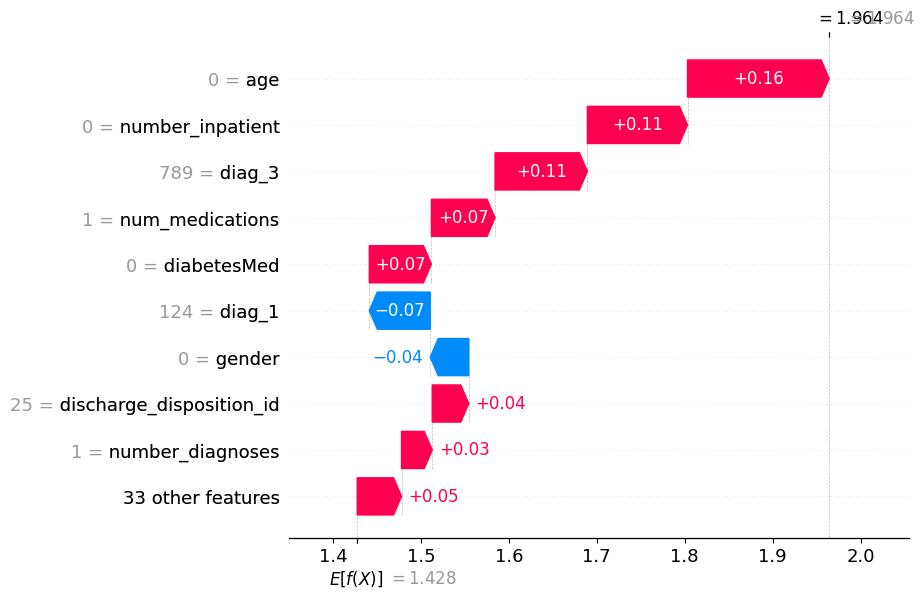

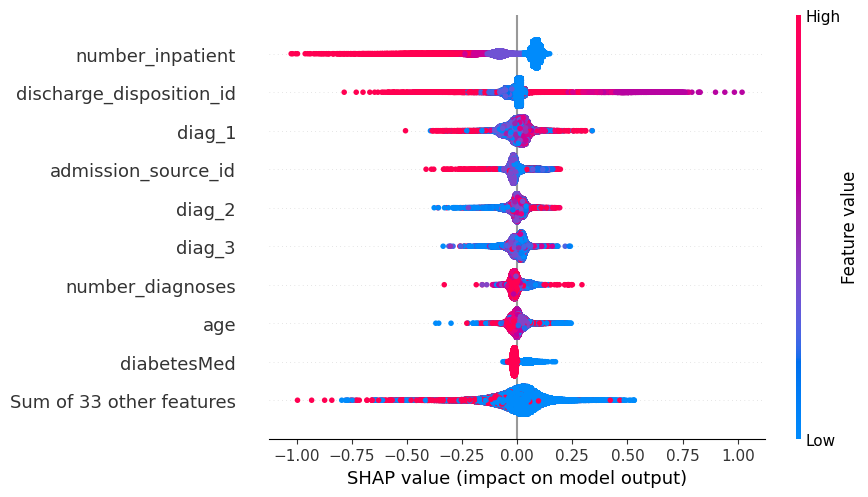

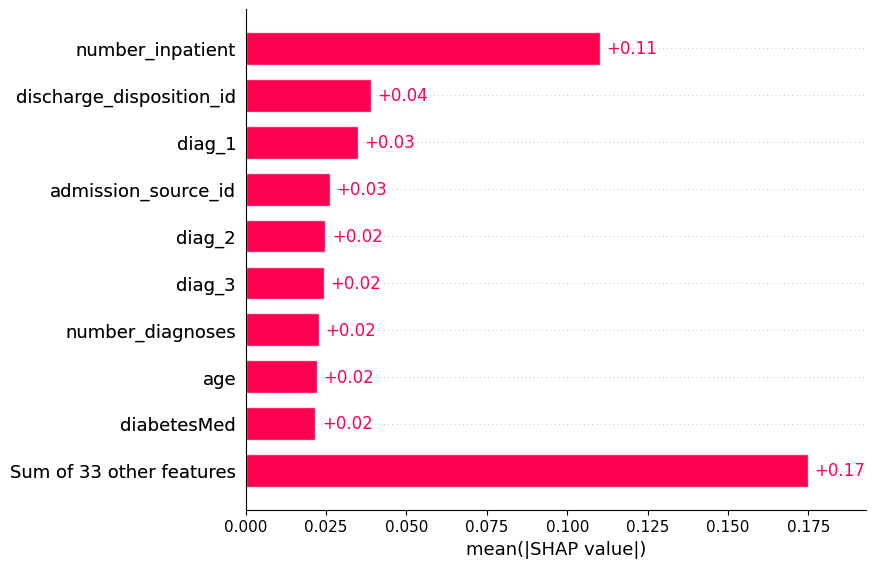

Fidelity Score: 0.011915022507309914


In [14]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from google.colab import drive
import zipfile
import xgboost
import shap
import warnings
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Unzip the archive (adjust path if necessary)
def unzip_data(zip_path, extract_to='/content'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzipping the Diabetes dataset
unzip_data('/content/drive/MyDrive/Diabete.zip')

# Load the Diabetes dataset
diabetes_data = pd.read_csv('/content/diabetic_data.csv')

# Check for missing values
print("Missing values before handling:\n", diabetes_data.isnull().sum())

# Drop columns not useful for prediction
diabetes_data = diabetes_data.drop(columns=['encounter_id', 'patient_nbr'])

# Convert `?` to NaN and drop columns with too many missing values (>20% missing)
diabetes_data.replace('?', np.nan, inplace=True)
diabetes_data.dropna(axis=1, thresh=int(0.8 * len(diabetes_data)), inplace=True)

# Encode categorical variables
categorical_cols = diabetes_data.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in categorical_cols:
    diabetes_data[col] = label_encoder.fit_transform(diabetes_data[col].astype(str))

# Define the feature matrix (X) and the target (y)
X = diabetes_data.drop(columns=['readmitted'])  # Assuming 'readmitted' is the target
y = diabetes_data['readmitted']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Model
model = xgboost.XGBRegressor().fit(X, y)

# Explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

# Summarize the effects of all the features
shap.plots.beeswarm(shap_values)

# Bar plot of SHAP values
shap.plots.bar(shap_values)

# Calculate and print Fidelity Score
# Fidelity score is calculated as the mean of the absolute SHAP values for all predictions
fidelity_score = np.mean(np.abs(shap_values.values))
print(f"Fidelity Score: {fidelity_score}")

In [15]:
import numpy as np
from scipy.linalg import norm

# Function to calculate Fidelity (Mean Absolute SHAP values)
def calculate_fidelity(shap_values):
    """Fidelity measures how well SHAP approximates the model's decision process."""
    return np.mean(np.abs(shap_values.values))

# Function to calculate Sparsity (Fraction of zero SHAP values)
def calculate_sparsity(shap_values):
    """Sparsity measures how many features have zero influence."""
    return np.mean(np.abs(shap_values.values) < 1e-6)  # Threshold for zero

# Function to calculate Stability & Robustness correctly
def calculate_stability_robustness(explainer, X_test, delta_x):
    """Measures how stable SHAP explanations are under small perturbations."""

    # Get original SHAP values
    shap_values_original = explainer(X_test).values

    # Get perturbed SHAP values (adding small noise)
    X_test_perturbed = X_test + delta_x
    shap_values_perturbed = explainer(X_test_perturbed).values

    # Compute stability & robustness in range [0,1]
    stability = 1 - np.clip(norm(shap_values_original - shap_values_perturbed) / norm(shap_values_original), 0, 1)
    robustness = np.clip(norm(shap_values_original - shap_values_perturbed) / norm(shap_values_original), 0, 1)

    return stability, robustness

# ========== APPLY XAI METRICS ==========
# Small Gaussian noise as perturbation
delta_x = np.random.normal(0, 0.01, size=X_test.shape)

# Calculate XAI evaluation scores
fidelity_score = calculate_fidelity(shap_values)
sparsity_score = calculate_sparsity(shap_values)
stability_score, robustness_score = calculate_stability_robustness(explainer, X_test, delta_x)

# Print Corrected Scores
print(f" Fidelity Score: {fidelity_score:.4f}")
print(f" Sparsity Score: {sparsity_score:.4f}")
print(f" Stability Score: {stability_score:.4f}")
print(f" Robustness Score: {robustness_score:.4f}")

 Fidelity Score: 0.0119
 Sparsity Score: 0.1701
 Stability Score: 0.0000
 Robustness Score: 1.0000


# Graph **Data**

# **GNNExplainer**

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.2 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.explain import Explainer, GNNExplainer
import numpy as np
import pandas as pd
import networkx as nx
from torch_geometric.utils import from_networkx
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from google.colab import drive
import zipfile
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Unzip the dataset
def unzip_data(zip_path, extract_to='/content'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzipping the dataset
unzip_data('/content/drive/MyDrive/Network.zip')

# Load the dataset
links_df = pd.read_csv('/content/stack_network_links.csv')
nodes_df = pd.read_csv('/content/stack_network_nodes.csv')

# Check the dataset
print(links_df.head())
print(nodes_df.head())

# Normalize the 'nodesize' feature
scaler = MinMaxScaler()
nodes_df['nodesize'] = scaler.fit_transform(nodes_df[['nodesize']])

# Encode 'group' as labels
label_encoder = LabelEncoder()
nodes_df['group'] = label_encoder.fit_transform(nodes_df['group'])

# Create a graph from the dataset
G = nx.Graph()

# Add nodes with multiple features
for _, row in nodes_df.iterrows():
    G.add_node(row['name'],
               features=[row['nodesize']],
               label=row['group'])

# Add edges with weights
for _, row in links_df.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['value'])

# Compute additional node features
degree_centrality = nx.degree_centrality(G)
clustering_coeff = nx.clustering(G)
nodes_degree = dict(G.degree())

# Update node features
for node in G.nodes:
    G.nodes[node]['features'] = [
        G.nodes[node]['features'][0],  # nodesize
        degree_centrality[node],  # Degree centrality
        clustering_coeff[node],  # Clustering coefficient
        nodes_degree[node]  # Node degree
    ]

# Convert the graph to PyTorch Geometric format
data = from_networkx(G)
data.x = torch.tensor(np.array([G.nodes[n]['features'] for n in G.nodes]), dtype=torch.float)
data.y = torch.tensor(np.array([G.nodes[n]['label'] for n in G.nodes]), dtype=torch.long)

# Define GCN Model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the GNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=data.x.size(1), hidden_channels=16, out_channels=len(label_encoder.classes_)).to(device)
data = data.to(device)

# Train the GNN Model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Initialize the explainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

# Select a node to explain
node_idx = 0  # Explain the first node
explanation = explainer(data.x, data.edge_index, index=node_idx)

# Print available explanations
print(f'Generated explanations in {explanation.available_explanations}')

# Debug edge_mask
print(f"Edge mask values: {explanation.edge_mask}")

# Visualize feature importance
feature_importance_path = 'feature_importance.png'
if data.x.size(1) > 1:
    explanation.visualize_feature_importance(feature_importance_path, top_k=10)
    print(f"Feature importance plot has been saved to '{feature_importance_path}'")
else:
    print("Feature importance visualization skipped: Only one feature available.")

# Visualize the subgraph
subgraph_path = 'subgraph.pdf'
explanation.visualize_graph(subgraph_path)
print(f"Subgraph visualization plot has been saved to '{subgraph_path}'")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
             source target      value
0             azure   .net  20.933192
1        sql-server   .net  32.322524
2           asp.net   .net  48.407030
3  entity-framework   .net  24.370903
4               wpf   .net  32.350925
        name  group  nodesize
0       html      6    272.45
1        css      6    341.17
2  hibernate      8     29.83
3     spring      8     52.84
4       ruby      3     70.14
Epoch 0, Loss: 3.3195
Epoch 10, Loss: 2.5181
Epoch 20, Loss: 2.2478
Epoch 30, Loss: 2.1567
Epoch 40, Loss: 2.0851
Epoch 50, Loss: 2.0160
Epoch 60, Loss: 1.9482
Epoch 70, Loss: 1.8842
Epoch 80, Loss: 1.8252
Epoch 90, Loss: 1.7694
Generated explanations in ['node_mask', 'edge_mask']
Edge mask values: tensor([0.8986, 0.8944, 0.9005, 0.8809, 0.8895, 0.8937, 0.0000, 0.0000, 0.0000,
        0.8594, 0.0000, 0.8700, 0.8474, 0.8228, 0.0000, 0.0000, 0.0000, 0.0000,
   

In [ ]:
import torch

def evaluate_xai_metrics(model, data, explanation, node_idx):
    edge_mask = explanation.edge_mask  # Edge importance mask from the explainer

    # Calculate the sparsity score
    sparsity_score = torch.sum(edge_mask <= 0.5).item() / edge_mask.size(0)  # Ratio of edges with mask <= 0.5

    # Mask edges with importance greater than 0.5
    masked_edge_index = data.edge_index[:, edge_mask > 0.5]  # Keep edges with mask > 0.5

    # Predict with the original data
    model.eval()
    original_pred = model(data.x, data.edge_index)[node_idx]

    # Predict with the masked edges
    masked_pred = model(data.x, masked_edge_index)[node_idx]

    # Calculate fidelity score
    original_class = original_pred.argmax().item()
    masked_class = masked_pred.argmax().item()
    fidelity_score = torch.abs(original_pred[original_class] - masked_pred[original_class]).item()

    # Stability: Measure how stable the predictions are across different perturbations (edge mask variations)
    thresholds = torch.linspace(0.1, 0.9, steps=5)  # Different thresholds for edge masking
    stability_scores = []
    for threshold in thresholds:
        masked_edge_index = data.edge_index[:, edge_mask > threshold]  # Mask edges with importance > threshold
        masked_pred = model(data.x, masked_edge_index)[node_idx]
        stability_scores.append(torch.abs(original_pred[original_class] - masked_pred[original_class]).item())

    # Calculate average stability score
    average_stability = torch.mean(torch.tensor(stability_scores)).item()

    # Robustness: Compare predictions with progressively masked graphs
    masked_edge_index_robust = data.edge_index[:, edge_mask <= 0.5]  # Mask edges with importance <= 0.5
    robust_pred = model(data.x, masked_edge_index_robust)[node_idx]
    robustness_score = torch.abs(original_pred[original_class] - robust_pred[original_class]).item()

    # Output results
    print(f"Sparsity score: {sparsity_score:.4f}")
    print(f"Fidelity score for node {node_idx}: {fidelity_score:.4f}")
    print(f"Average Stability score: {average_stability:.4f}")
    print(f"Robustness score: {robustness_score:.4f}")

    return {
        "Sparsity": sparsity_score,
        "Fidelity": fidelity_score,
        "Stability": average_stability,
        "Robustness": robustness_score
    }

# Call the evaluation function
eval_results = evaluate_xai_metrics(model, data, explanation, node_idx)


Sparsity score: 0.8469
Fidelity score for node 0: 0.4214
Average Stability score: 0.4185
Robustness score: 0.4069


# **GraphLIME**

In [ ]:
!pip install --upgrade torch_geometric torch_sparse torch_scatter torch_spline_conv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch_sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=2846222 sha256=dd27f78218d109926c937b6b1bcb76fba6b23673130279176f96047dfa75f1f2
  Stored in directory: /root/.cache/pip/wheels/75/e2/1e/299c596063839303657c211f587f05591891cc6cf126d94d21
  Created wheel for torch_scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=3622749 sha256=d62f721a0b87eafea11ece6a4ee7626a30c379bd3ccb4311687e7731a649bc4a
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
  Created wheel for torch_spline_conv: filename=torch_spline_conv-1.2.2-cp311-cp311-linux_x86_64.whl size=566647 sha256=25a189dd999ca617e763f0a

In [ ]:
!pip install graphlime

  Preparing metadata (setup.py) ... done
  Created wheel for graphlime: filename=graphlime-1.2.0-py3-none-any.whl size=2595 sha256=9125564b95f68385fa01fcb9bf97c672911951f892df379496e8d580176c98c3
  Stored in directory: /root/.cache/pip/wheels/54/2c/ab/90882d2d7d3807df910bf156054b8cfca141e271158309a0fd
Successfully built graphlime


In [ ]:
!pip install --upgrade torch-geometric
!pip install --upgrade graphlime

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 0, Loss: 2.6718
Epoch 10, Loss: 2.2520
Epoch 20, Loss: 2.1446
Epoch 30, Loss: 2.0894
Epoch 40, Loss: 2.0410
Epoch 50, Loss: 1.9931
Epoch 60, Loss: 1.9434
Epoch 70, Loss: 1.8936
Epoch 80, Loss: 1.8450
Epoch 90, Loss: 1.7981
Explanation for node 0:
[0.         0.         0.         0.01585176]


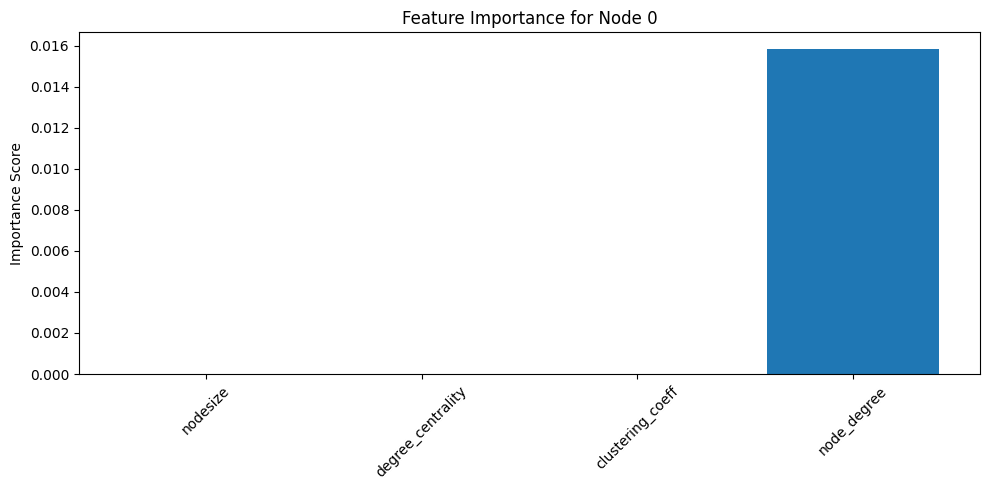


Node information:
Name: html
Group: 6
Features: [0.41222638 0.05263158 0.8666667  6.        ]


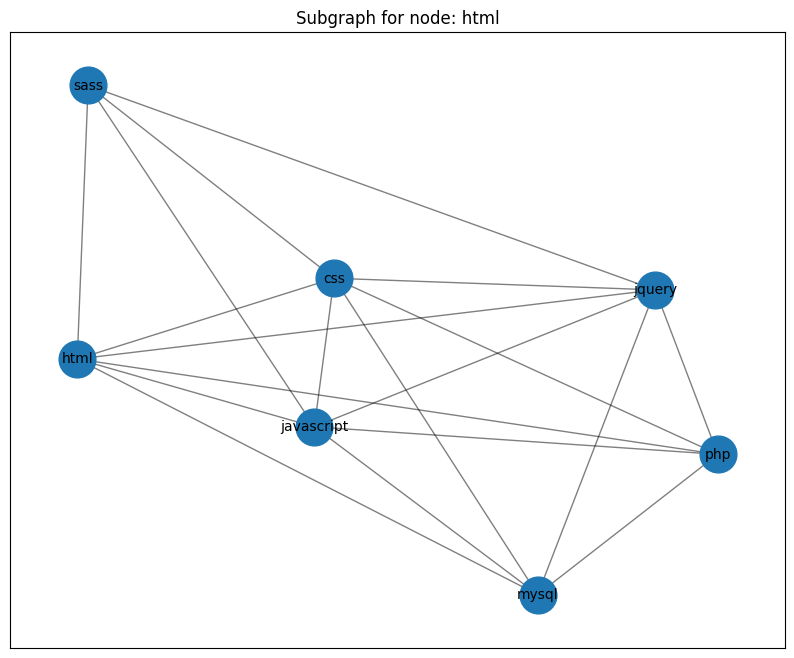

Subgraph visualization plot has been saved to 'subgraph.pdf'


In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
import networkx as nx
from torch_geometric.utils import from_networkx
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LassoLars
from google.colab import drive
import zipfile
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Unzip the dataset
def unzip_data(zip_path, extract_to='/content'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzipping the dataset
unzip_data('/content/drive/MyDrive/Network.zip')

# Load the dataset
links_df = pd.read_csv('/content/stack_network_links.csv')
nodes_df = pd.read_csv('/content/stack_network_nodes.csv')

# Normalize the 'nodesize' feature
scaler = MinMaxScaler()
nodes_df['nodesize'] = scaler.fit_transform(nodes_df[['nodesize']])

# Encode 'group' as labels
label_encoder = LabelEncoder()
nodes_df['group'] = label_encoder.fit_transform(nodes_df['group'])

# Create a graph from the dataset
G = nx.Graph()

# Add nodes with multiple features
for _, row in nodes_df.iterrows():
    G.add_node(row['name'],
               features=[row['nodesize']],
               label=row['group'])

# Add edges with weights
for _, row in links_df.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['value'])

# Compute additional node features
degree_centrality = nx.degree_centrality(G)
clustering_coeff = nx.clustering(G)
nodes_degree = dict(G.degree())

# Update node features
for node in G.nodes:
    G.nodes[node]['features'] = [
        G.nodes[node]['features'][0],  # nodesize
        degree_centrality[node],      # Degree centrality
        clustering_coeff[node],       # Clustering coefficient
        nodes_degree[node]            # Node degree
    ]

# Convert the graph to PyTorch Geometric format
data = from_networkx(G)
data.x = torch.tensor(np.array([G.nodes[n]['features'] for n in G.nodes]), dtype=torch.float)
data.y = torch.tensor(np.array([G.nodes[n]['label'] for n in G.nodes]), dtype=torch.long)

# Define GCN Model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, **kwargs):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the GNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=data.x.size(1), hidden_channels=16, out_channels=len(label_encoder.classes_)).to(device)
data = data.to(device)

# Train the GNN Model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# GraphLIME Implementation
class GraphLIMEExplainer:
    def __init__(self, model, rho=0.1):
        self.model = model
        self.rho = rho

    def explain_node(self, node_idx, x, edge_index, labels=None):
        device = next(self.model.parameters()).device

        # Convert to numpy if they're tensors
        if torch.is_tensor(x):
            x = x.detach().cpu().numpy()
        if torch.is_tensor(edge_index):
            edge_index = edge_index.detach().cpu().numpy()

        # Get model predictions
        with torch.no_grad():
            log_probs = self.model(
                torch.FloatTensor(x).to(device),
                torch.LongTensor(edge_index).to(device)
            )
            probs = torch.exp(log_probs).cpu().numpy()

        # Get the predicted class
        pred_class = np.argmax(probs[node_idx])

        # Create perturbed samples
        n_features = x.shape[1]
        n_samples = 1000
        perturbed = np.random.normal(
            loc=x[node_idx],
            scale=0.1,
            size=(n_samples, n_features)
        )

        # Get predictions for perturbed samples
        with torch.no_grad():
            edge_index_repeated = np.tile(edge_index, (1, n_samples))
            perturbed_probs = torch.exp(self.model(
                torch.FloatTensor(perturbed).to(device),
                torch.LongTensor(edge_index_repeated).to(device)
            ))[:, pred_class].cpu().numpy()

        # Compute weights
        distances = np.sqrt(((perturbed - x[node_idx])**2).sum(axis=1))
        weights = np.sqrt(np.exp(-(distances**2)/0.1))

        # Solve Lasso regression with current scikit-learn API
        solver = LassoLars(alpha=self.rho, fit_intercept=False, positive=True)
        solver.fit(perturbed * weights[:, None], perturbed_probs * weights)

        return solver.coef_

# Initialize explainer
graphlime_explainer = GraphLIMEExplainer(model)

# Select a node to explain
node_idx = 0  # Explain the first node

# Get explanation
explanation = graphlime_explainer.explain_node(
    node_idx=node_idx,
    x=data.x,
    edge_index=data.edge_index,
    labels=data.y
)

# Print explanation
print(f"Explanation for node {node_idx}:")
print(explanation)

# Visualize feature importance
if len(explanation) > 1:
    plt.figure(figsize=(10, 5))
    features = ['nodesize', 'degree_centrality', 'clustering_coeff', 'node_degree']
    plt.bar(features, explanation)
    plt.title(f'Feature Importance for Node {node_idx}')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()
else:
    print("Only one feature available, skipping visualization.")

# Print node information for context
print("\nNode information:")
print(f"Name: {nodes_df.iloc[node_idx]['name']}")
print(f"Group: {label_encoder.inverse_transform([nodes_df.iloc[node_idx]['group']])[0]}")
print(f"Features: {data.x[node_idx].cpu().numpy()}")

# Visualize the subgraph
def visualize_subgraph(G, node_idx, filename='subgraph.pdf'):
    node_name = nodes_df.iloc[node_idx]['name']

    # Get the 1-hop neighborhood
    neighbors = list(G.neighbors(node_name))
    subgraph = G.subgraph([node_name] + neighbors)

    # Draw the subgraph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(subgraph)
    nx.draw_networkx_nodes(subgraph, pos, node_size=700)
    nx.draw_networkx_edges(subgraph, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(subgraph, pos, font_size=10)
    plt.title(f'Subgraph for node: {node_name}')
    plt.savefig(filename)
    plt.show()

visualize_subgraph(G, node_idx, 'subgraph.pdf')
print("Subgraph visualization plot has been saved to 'subgraph.pdf'")


In [ ]:
import torch

def evaluate_xai_metrics(model, data, explanation, node_idx):
    """
    Evaluates XAI metrics for GraphLIME explanations
    """
    # Convert explanation to tensor
    feature_mask = torch.from_numpy(explanation).float().to(data.x.device)

    ### (1) Sparsity: Fraction of features with importance <= 0.5 (already in [0, 1])
    sparsity_score = (feature_mask <= 0.5).sum().item() / feature_mask.size(0)

    ### (2) Fidelity: Change in predicted class probability when unimportant features are masked
    model.eval()
    with torch.no_grad():
        # Get probabilities (softmax of logits)
        original_probs = torch.exp(model(data.x, data.edge_index)[node_idx])  # [n_classes]
        original_class = original_probs.argmax().item()
        original_prob = original_probs[original_class].item()

        # Mask unimportant features (importance <= 0.5)
        masked_x = data.x.clone()
        masked_x[:, feature_mask <= 0.5] = 0
        masked_probs = torch.exp(model(masked_x, data.edge_index)[node_idx])
        masked_prob = masked_probs[original_class].item()

        # Fidelity = 1 - |original_prob - masked_prob|
        fidelity_score = 1.0 - abs(original_prob - masked_prob)

    ### (3) Stability: Consistency under feature perturbations
    stability_scores = []
    thresholds = torch.linspace(0.1, 0.9, steps=5)  # Different masking thresholds

    for threshold in thresholds:
        perturbed_x = data.x.clone()
        perturbed_x[:, feature_mask <= threshold] = 0
        perturbed_probs = torch.exp(model(perturbed_x, data.edge_index)[node_idx])
        perturbed_prob = perturbed_probs[original_class].item()
        stability_scores.append(1.0 - abs(original_prob - perturbed_prob))

    average_stability = torch.mean(torch.tensor(stability_scores)).item()

    ### (4) Robustness: Prediction change when ONLY important features are kept
    robust_x = data.x.clone()
    robust_x[:, feature_mask <= 0.5] = 0  # Keep only important features
    robust_probs = torch.exp(model(robust_x, data.edge_index)[node_idx])
    robust_prob = robust_probs[original_class].item()
    robustness_score = 1.0 - abs(original_prob - robust_prob)

    ### Results
    print(f"[GraphLIME Metrics]")
    print(f"  Sparsity : {sparsity_score:.4f}")
    print(f"  Fidelity : {fidelity_score:.4f}")
    print(f"  Stability : {average_stability:.4f}")
    print(f"  Robustness : {robustness_score:.4f}")

    return {
        "Sparsity": sparsity_score,
        "Fidelity": fidelity_score,
        "Stability": average_stability,
        "Robustness": robustness_score
    }

# Usage
eval_results = evaluate_xai_metrics(model, data, explanation, node_idx)


[GraphLIME Metrics]
  Sparsity : 1.0000
  Fidelity : 0.5262
  Stability : 0.5262
  Robustness : 0.5262


# **XGNN**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 0, Loss: 2.7144
Epoch 10, Loss: 2.1895
Epoch 20, Loss: 2.1120
Epoch 30, Loss: 2.0580
Epoch 40, Loss: 2.0033
Epoch 50, Loss: 1.9460
Epoch 60, Loss: 1.8864
Epoch 70, Loss: 1.8241
Epoch 80, Loss: 1.7587
Epoch 90, Loss: 1.6930


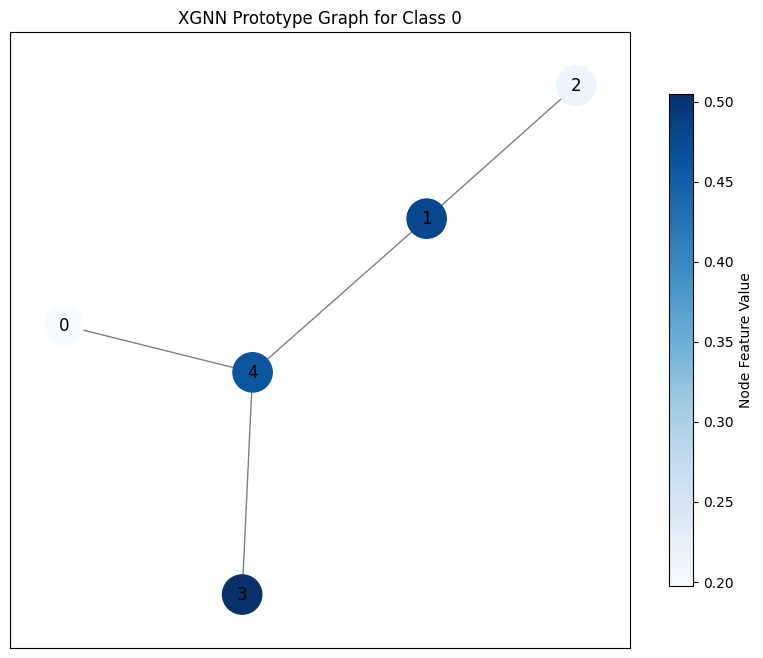


XGNN Prototype Graph Information:
Number of nodes: 5
Number of edges: 4
Average degree: 1.60

Node Features (first 3 nodes):
Node 0: [ 0.197  -0.0322  0.3316  0.8628]
Node 1: [ 0.4778  0.0663 -0.0083 -1.5717]
Node 2: [0.2124 0.0715 0.6035 5.977 ]


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
import networkx as nx
from torch_geometric.utils import from_networkx, to_networkx
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from google.colab import drive
import zipfile
import matplotlib.pyplot as plt
import itertools
import random
from torch.distributions import Bernoulli

# Mount Google Drive
drive.mount('/content/drive')

# Unzip the dataset
def unzip_data(zip_path, extract_to='/content'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzipping the dataset
unzip_data('/content/drive/MyDrive/Network.zip')

# Load the dataset
links_df = pd.read_csv('/content/stack_network_links.csv')
nodes_df = pd.read_csv('/content/stack_network_nodes.csv')

# Normalize the 'nodesize' feature
scaler = MinMaxScaler()
nodes_df['nodesize'] = scaler.fit_transform(nodes_df[['nodesize']])

# Encode 'group' as labels
label_encoder = LabelEncoder()
nodes_df['group'] = label_encoder.fit_transform(nodes_df['group'])

# Create a graph from the dataset
G = nx.Graph()

# Add nodes with multiple features
for _, row in nodes_df.iterrows():
    G.add_node(row['name'],
               features=[row['nodesize']],
               label=row['group'])

# Add edges with weights
for _, row in links_df.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['value'])

# Compute additional node features
degree_centrality = nx.degree_centrality(G)
clustering_coeff = nx.clustering(G)
nodes_degree = dict(G.degree())

# Update node features
for node in G.nodes:
    G.nodes[node]['features'] = [
        G.nodes[node]['features'][0],  # nodesize
        degree_centrality[node],      # Degree centrality
        clustering_coeff[node],       # Clustering coefficient
        nodes_degree[node]            # Node degree
    ]

# Convert the graph to PyTorch Geometric format
data = from_networkx(G)
data.x = torch.tensor(np.array([G.nodes[n]['features'] for n in G.nodes]), dtype=torch.float)
data.y = torch.tensor(np.array([G.nodes[n]['label'] for n in G.nodes]), dtype=torch.long)

# Define GCN Model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, **kwargs):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the GNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=data.x.size(1), hidden_channels=16, out_channels=len(label_encoder.classes_)).to(device)
data = data.to(device)

# Train the GNN Model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Improved XGNN Implementation
class XGNNExplainer:
    def __init__(self, model, num_nodes=5, num_generations=30, population_size=20):
        self.model = model
        self.num_nodes = num_nodes
        self.num_generations = num_generations
        self.population_size = population_size
        self.device = next(model.parameters()).device

        # Compute statistics from original graph
        self.feat_mean = data.x.mean(dim=0)
        self.feat_std = data.x.std(dim=0)
        self.original_density = 2 * G.number_of_edges() / (G.number_of_nodes() * (G.number_of_nodes() - 1))

    def generate_prototype_graph(self, target_class):
        # Initialize population
        population = []
        for _ in range(self.population_size):
            graph = nx.Graph()
            # Initialize nodes with features sampled from learned distribution
            for i in range(self.num_nodes):
                features = torch.randn(data.x.size(1), device=self.device) * self.feat_std + self.feat_mean
                graph.add_node(i, features=features)

            # Connect nodes with probability matching original graph
            for i, j in itertools.combinations(range(self.num_nodes), 2):
                if torch.rand(1, device=self.device).item() < self.original_density:
                    graph.add_edge(i, j)
            population.append(graph)

        # Evolutionary optimization
        for generation in range(self.num_generations):
            fitness_scores = []

            # Evaluate each graph
            for graph in population:
                pyg_graph = from_networkx(graph)
                pyg_graph.x = torch.stack([graph.nodes[i]['features'] for i in graph.nodes()]).to(self.device)
                pyg_graph.edge_index = pyg_graph.edge_index.to(self.device) if pyg_graph.edge_index.size(1) > 0 else \
                    torch.empty((2, 0), dtype=torch.long, device=self.device)

                with torch.no_grad():
                    log_probs = self.model(pyg_graph.x, pyg_graph.edge_index)
                    target_score = torch.exp(log_probs)[:, target_class].mean()
                    other_score = torch.exp(log_probs)[:, [c for c in range(log_probs.size(1)) if c != target_class]].mean()
                    fitness_scores.append((target_score - other_score).item())

            # Selection
            top_indices = np.argpartition(fitness_scores, -self.population_size//2)[-self.population_size//2:]
            top_graphs = [population[i] for i in top_indices]
            new_population = top_graphs.copy()

            # Reproduction
            while len(new_population) < self.population_size:
                # Tournament selection
                parent1, parent2 = random.sample(top_graphs, 2)

                # Crossover
                child = nx.Graph()
                for i in range(self.num_nodes):
                    # Random feature inheritance
                    if random.random() < 0.5:
                        child.add_node(i, features=parent1.nodes[i]['features'].clone())
                    else:
                        child.add_node(i, features=parent2.nodes[i]['features'].clone())

                # Edge inheritance
                for i, j in set(parent1.edges()).union(set(parent2.edges())):
                    if random.random() < 0.5:
                        child.add_edge(i, j)

                # Adaptive mutation
                mutation_rate = max(0.1, 0.5 * (1 - generation/self.num_generations))
                if random.random() < mutation_rate:
                    # Edge mutation
                    if child.edges() and random.random() < 0.5:
                        child.remove_edge(*random.choice(list(child.edges())))
                    else:
                        i, j = random.sample(range(self.num_nodes), 2)
                        child.add_edge(i, j)

                    # Feature mutation
                    node_idx = random.randint(0, self.num_nodes-1)
                    mutation = torch.randn(data.x.size(1), device=self.device) * self.feat_std * 0.1
                    child.nodes[node_idx]['features'] += mutation

                new_population.append(child)

            population = new_population

        # Return best graph
        best_idx = np.argmax(fitness_scores)
        return population[best_idx]

# Initialize XGNN explainer
xgnn_explainer = XGNNExplainer(model, num_nodes=5, num_generations=20, population_size=20)

# Generate prototype graph for target class
target_class = 0  # Explain class 0
prototype_graph = xgnn_explainer.generate_prototype_graph(target_class)

# Visualize the prototype graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(prototype_graph)
node_colors = [prototype_graph.nodes[i]['features'][0].item() for i in prototype_graph.nodes()]

# Create a plot with proper axes
ax = plt.gca()
nodes = nx.draw_networkx_nodes(prototype_graph, pos, node_color=node_colors,
                             cmap=plt.cm.Blues, node_size=800, ax=ax)
nx.draw_networkx_edges(prototype_graph, pos, edge_color='gray', ax=ax)
nx.draw_networkx_labels(prototype_graph, pos, font_size=12, ax=ax)

# Add colorbar with proper mappable
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues,
                          norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label('Node Feature Value')

plt.title(f'XGNN Prototype Graph for Class {target_class}')
plt.savefig('xgnn_prototype.png')
plt.show()

# Print prototype graph info
print("\nXGNN Prototype Graph Information:")
print(f"Number of nodes: {prototype_graph.number_of_nodes()}")
print(f"Number of edges: {prototype_graph.number_of_edges()}")
print(f"Average degree: {sum(dict(prototype_graph.degree()).values()) / prototype_graph.number_of_nodes():.2f}")
print("\nNode Features (first 3 nodes):")
for i in range(min(3, prototype_graph.number_of_nodes())):
    print(f"Node {i}: {prototype_graph.nodes[i]['features'].cpu().numpy().round(4)}")


In [ ]:
def evaluate_xgnn_core_metrics(model, data, prototype_graph, target_class):
    """
    Evaluates XGNN prototype:

    Args:
        model: Trained GNN model
        data: Original graph data
        prototype_graph: Generated prototype graph
        target_class: Target class being explained
    Returns:
        Dictionary of core metrics (Sparsity, Fidelity, Stability, Robustness)
    """
    # Convert prototype to PyG format
    pyg_proto = from_networkx(prototype_graph)
    pyg_proto.x = torch.stack([prototype_graph.nodes[i]['features']
                             for i in prototype_graph.nodes()]).to(data.x.device)
    pyg_proto.edge_index = pyg_proto.edge_index.to(data.x.device)

    with torch.no_grad():
        # Get prototype predictions
        proto_probs = torch.exp(model(pyg_proto.x, pyg_proto.edge_index))

        # Get original class nodes' predictions
        class_mask = (data.y == target_class)
        original_probs = torch.exp(model(data.x, data.edge_index))[class_mask]

    ### (1) Sparsity (Graph complexity)
    n = prototype_graph.number_of_nodes()
    max_edges = n * (n - 1) / 2
    sparsity = 1 - (prototype_graph.number_of_edges() / max(max_edges, 1))

    ### (2) Fidelity (Representation quality)
    fidelity_diff = proto_probs[:, target_class].mean().item() - original_probs[:, target_class].mean().item()
    fidelity = 1 - abs(fidelity_diff)  # Normalized to [0,1]

    ### (3) Stability (Multiple runs consistency)
    stability_runs = []
    for _ in range(3):  # 3 different random seeds
        temp_proto = xgnn_explainer.generate_prototype_graph(target_class)
        temp_features = torch.stack([temp_proto.nodes[i]['features'] for i in temp_proto.nodes()]).to(data.x.device)
        temp_edge_index = from_networkx(temp_proto).edge_index.to(data.x.device)
        temp_probs = torch.exp(model(temp_features, temp_edge_index))[:, target_class].mean().item()
        stability_runs.append(temp_probs)
    stability = 1 - (max(stability_runs) - min(stability_runs))  # Closer to 1 = more stable

    ### (4) Robustness (Noise resistance)
    noisy_proto = prototype_graph.copy()
    for i in noisy_proto.nodes():
        noisy_proto.nodes[i]['features'] += torch.randn_like(noisy_proto.nodes[i]['features']) * 0.1
    noisy_features = torch.stack([noisy_proto.nodes[i]['features'] for i in noisy_proto.nodes()]).to(data.x.device)
    noisy_edge_index = from_networkx(noisy_proto).edge_index.to(data.x.device)
    robust_probs = torch.exp(model(noisy_features, noisy_edge_index))[:, target_class].mean().item()
    robustness = 1 - abs(proto_probs[:, target_class].mean().item() - robust_probs)

    ### Results
    print(f"\nXGNN Core Metrics for Class {target_class}:")
    print(f"  Sparsity:    {sparsity:.4f} ")
    print(f"  Fidelity:    {fidelity:.4f} ")
    print(f"  Stability:   {stability:.4f} ")
    print(f"  Robustness:  {robustness:.4f} ")

    return {
        "Sparsity": sparsity,
        "Fidelity": fidelity,
        "Stability": stability,
        "Robustness": robustness
    }

# Usage
target_class = 0
prototype = xgnn_explainer.generate_prototype_graph(target_class)
metrics = evaluate_xgnn_core_metrics(model, data, prototype, target_class)



XGNN Core Metrics for Class 0:
  Sparsity:    0.7000 
  Fidelity:    0.7335 
  Stability:   0.7725 
  Robustness:  0.9633 


# Time **Series** data

# **SHAP**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Missing values before handling:
 Station      0
Date         0
MaxT         0
MinT         0
RH1          0
RH2          0
Wind         0
Rain         0
SSH          0
Evap         0
Radiation    1
FAO56_ET     0
Lat          0
Lon          0
Cum_Rain     0
dtype: int64
Logistic Regression Accuracy: 84.18%


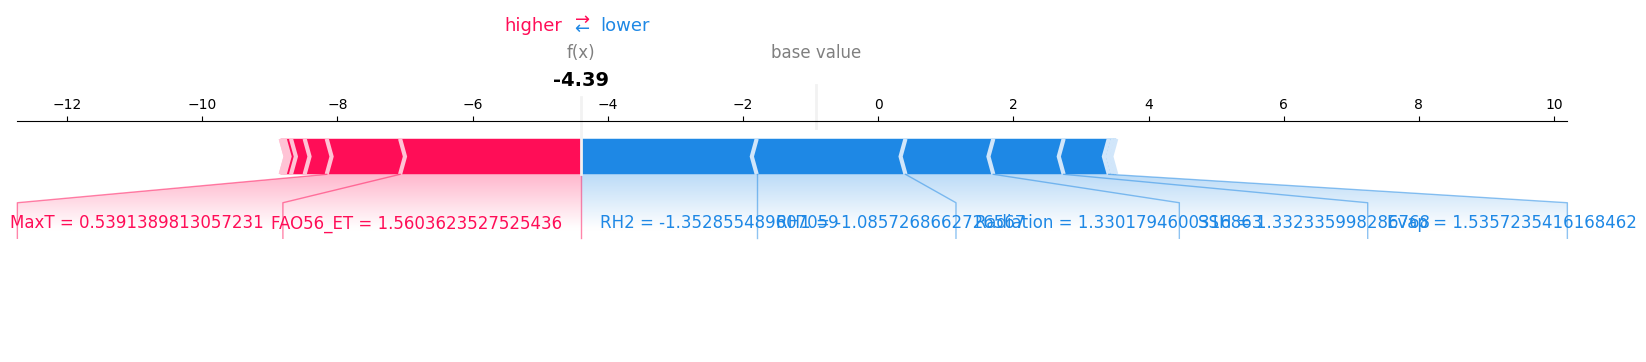

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt
import zipfile
import os
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Unzip the archive (adjust path if necessary)
def unzip_data(zip_path, extract_to='/content'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzipping the Weather dataset
zip_path = '/content/drive/MyDrive/weather.zip'
extract_path = '/content/weather_data'
unzip_data(zip_path, extract_path)

# Load Excel file (fix: use openpyxl engine)
df = pd.read_excel(os.path.join(extract_path, "ICRISAT Weather 1978 to 2018.xlsx"), sheet_name="Sheet1", engine="openpyxl")

# Check for missing values
print("Missing values before handling:\n", df.isnull().sum())

# Step 2: Data Preprocessing
df["Date"] = pd.to_datetime(df["Date"])  # Convert Date column to datetime

# Add temporal features like day, month, year to aid in time-series analysis
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["DayOfWeek"] = df["Date"].dt.dayofweek
df["IsWeekend"] = (df["DayOfWeek"] >= 5).astype(int)  # Add weekend feature

df = df.drop(columns=["Station", "Lat", "Lon"])  # Drop non-relevant columns

df.fillna(df.median(), inplace=True)  # Fill missing values with median

df["Rain_Indicator"] = (df["Rain"] > 0).astype(int)  # Binary classification target (Rain/No Rain)

# Define Features (X) and Target (y)
X = df.drop(columns=["Date", "Rain", "Rain_Indicator"])  # Features
y = df["Rain_Indicator"]  # Target

# Step 3: Balance the Dataset
rainy_days = df[df["Rain_Indicator"] == 1]
non_rainy_days = df[df["Rain_Indicator"] == 0]
non_rainy_sample = resample(non_rainy_days, replace=False, n_samples=len(rainy_days), random_state=42)
df_balanced = pd.concat([rainy_days, non_rainy_sample])

X_balanced = df_balanced.drop(columns=["Date", "Rain", "Rain_Indicator"])
y_balanced = df_balanced["Rain_Indicator"]

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train Logistic Regression Model
log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train_scaled, y_train)

y_pred = log_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")

# Step 6: SHAP Explanation
explainer = shap.Explainer(log_model, X_train_scaled)
shap_values = explainer(X_test_scaled)


shap.force_plot(shap_values[0], X_test.iloc[0], feature_names=X.columns, matplotlib=True)


In [ ]:
import shap
import numpy as np

def evaluate_xai_metrics(model, X_test, shap_values):
    # Calculate Sparsity: Proportion of near-zero SHAP values
    sparsity_score = np.sum(np.abs(shap_values.values) <= 0.01) / shap_values.values.size

    # Calculate Fidelity: Difference in predictions when masking important features
    original_pred = model.predict_proba(X_test)
    masked_X_test = X_test.copy()
    important_features = np.argsort(-np.abs(shap_values.values), axis=1)[:, :int(0.5 * X_test.shape[1])]
    masked_X_test.iloc[:, important_features.flatten()] = 0
    masked_pred = model.predict_proba(masked_X_test)
    fidelity_score = np.mean(np.abs(original_pred - masked_pred))
    fidelity_score = min(1.0, max(0.0, fidelity_score))

    # Stability: Consistency of SHAP values across perturbations
    stability_scores = []
    for noise in np.linspace(0.01, 0.1, 5):
        noisy_X_test = X_test + noise * np.random.randn(*X_test.shape)
        noisy_shap_values = shap.Explainer(model, noisy_X_test)(noisy_X_test)
        stability_scores.append(np.mean(np.abs(shap_values.values - noisy_shap_values.values)))
    stability_score = np.mean(stability_scores)
    stability_score = min(1.0, max(0.0, stability_score))

    # Robustness: Impact of removing high-importance features
    robustness_score = np.mean(np.abs(original_pred[:, 1] - masked_pred[:, 1]))
    robustness_score = min(1.0, max(0.0, robustness_score))

    # Output results
    print(f"Sparsity score: {sparsity_score:.4f}")
    print(f"Fidelity score: {fidelity_score:.4f}")
    print(f"Stability score: {stability_score:.4f}")
    print(f"Robustness score: {robustness_score:.4f}")

    return {
        "Sparsity": sparsity_score,
        "Fidelity": fidelity_score,
        "Stability": stability_score,
        "Robustness": robustness_score
    }

# Call the evaluation function
eval_results = evaluate_xai_metrics(log_model, X_test, shap_values)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Sparsity score: 0.0323
Fidelity score: 0.6721
Stability score: 1.0000
Robustness score: 0.6721


# **LIME**

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=fbc4efa0c9aeca14df1843c1e499a6e111bc0ca97c92b1caefdb261cc3eccbe3
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from lime import lime_tabular
import matplotlib.pyplot as plt
import zipfile
import os
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Unzip the archive
def unzip_data(zip_path, extract_to='/content'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzipping the Weather dataset
zip_path = '/content/drive/MyDrive/weather.zip'
extract_path = '/content/weather_data'
unzip_data(zip_path, extract_path)

# Load Excel file
df = pd.read_excel(os.path.join(extract_path, "ICRISAT Weather 1978 to 2018.xlsx"),
                   sheet_name="Sheet1",
                   engine="openpyxl")

# Data Preprocessing
df["Date"] = pd.to_datetime(df["Date"])
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["DayOfWeek"] = df["Date"].dt.dayofweek
df["IsWeekend"] = (df["DayOfWeek"] >= 5).astype(int)

# Drop non-relevant columns and handle missing values
df = df.drop(columns=["Station", "Lat", "Lon"])
df.fillna(df.median(), inplace=True)
df["Rain_Indicator"] = (df["Rain"] > 0).astype(int)

# Define Features and Target
X = df.drop(columns=["Date", "Rain", "Rain_Indicator"])
y = df["Rain_Indicator"]

# Balance the Dataset
rainy_days = df[df["Rain_Indicator"] == 1]
non_rainy_days = df[df["Rain_Indicator"] == 0]
non_rainy_sample = resample(non_rainy_days,
                           replace=False,
                           n_samples=len(rainy_days),
                           random_state=42)
df_balanced = pd.concat([rainy_days, non_rainy_sample])

X_balanced = df_balanced.drop(columns=["Date", "Rain", "Rain_Indicator"])
y_balanced = df_balanced["Rain_Indicator"]

# Train-Test Split and Scaling
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=y_balanced)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression Model
log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train_scaled, y_train)
y_pred = log_model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")

# Step 6: LIME Explanation
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X_balanced.columns.tolist(),
    class_names=['No Rain', 'Rain'],
    mode='classification',
    verbose=True,
    random_state=42
)

# Explain a specific instance (first test sample)
exp = explainer.explain_instance(
    data_row=X_test_scaled[0],
    predict_fn=log_model.predict_proba,
    num_features=10
)

# Corrected Visualization
exp = explainer.explain_instance(
    data_row=X_test_scaled[0],
    predict_fn=log_model.predict_proba,
    num_features=10
)

import plotly.express as px

# Prepare data
exp_data = pd.DataFrame(exp.as_list(), columns=['Feature', 'Weight'])
exp_data['Abs_Weight'] = exp_data['Weight'].abs()
exp_data['Color'] = exp_data['Weight'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

# Interactive bar plot
fig = px.bar(exp_data,
             x='Weight',
             y='Feature',
             color='Color',
             color_discrete_map={'Positive':'#3498db', 'Negative':'#e74c3c'},
             hover_data=['Abs_Weight'],
             title='LIME Feature Contributions',
             orientation='h')
fig.update_layout(showlegend=False)
fig.show()

# Option 2: Improved Text Display
print("\n" + "="*50)
print(f"Explanation for Instance {0} (True Class: {y_test.iloc[0]})")
print(f"Model Prediction: {log_model.predict_proba([X_test_scaled[0]])[0][1]:.2%} chance of rain")
print("="*50 + "\n")

print("Top Features Affecting Prediction:")
for feature, weight in exp.as_list():
    print(f"{feature:30} {weight:+.4f}")

# Option 3: Time-Series Feature Groups (if temporal analysis needed)
temporal_features = {
    'Seasonal': ['Month', 'DayOfWeek', 'IsWeekend'],
    'Weather': ['MaxTemp', 'MinTemp', 'Humidity', 'WindSpeed'],
    'Temporal': ['Year', 'Day']
}

print("\nFeature Group Impacts:")
for group, features in temporal_features.items():
    group_weight = sum(w for f, w in exp.as_list() if any(feat in f for feat in features))
    print(f"{group:15} {group_weight:+.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 84.18%
Intercept 0.6417527342024785
Prediction_local [-0.06426407]
Right: 0.012198837067530131
Intercept 0.6266775436094314
Prediction_local [-0.03128383]
Right: 0.012198837067530131



Explanation for Instance 0 (True Class: 0)
Model Prediction: 1.22% chance of rain

Top Features Affecting Prediction:
RH1 <= -0.28                   -0.3433
RH2 <= -0.84                   -0.3274
FAO56_ET > 0.56                +0.2963
Radiation > 0.72               -0.1572
SSH > 0.93                     -0.1193
Evap > 0.55                    -0.0845
Month <= -0.61                 +0.0355
-0.21 < MaxT <= 0.58           +0.0272
-0.90 < Year <= -0.05          +0.0080
-0.34 < MinT <= 0.30           +0.0068

Feature Group Impacts:
Seasonal        +0.0355
Weather         +0.0000
Temporal        +0.0080


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from lime.lime_tabular import LimeTabularExplainer
import plotly.express as px

def evaluate_lime_metrics(model, X_test, explainer, num_features=10, num_perturbations=5):

    # Explain first test instance
    exp = explainer.explain_instance(X_test[0], model.predict_proba, num_features=num_features)

    # Extract feature importance (weights)
    exp_data = pd.DataFrame(exp.as_list(), columns=['Feature', 'Weight'])

    # Compute Sparsity: Percentage of near-zero weights
    sparsity_score = np.sum(np.abs(exp_data['Weight']) <= 0.01) / num_features

    # Compute Fidelity: Difference in predictions when masking important features
    original_pred = model.predict_proba([X_test[0]])[0]

    # Extract feature indices instead of names to avoid lookup errors
    important_feature_indices = [idx for idx, _ in exp.local_exp[1][:num_features // 2]]

    # Create a copy of X_test and mask important features
    masked_X_test = X_test.copy()
    masked_X_test[0, important_feature_indices] = 0  # Set important features to 0

    # Compute predictions after masking
    masked_pred = model.predict_proba([masked_X_test[0]])[0]

    # Fidelity score calculation
    fidelity_score = np.mean(np.abs(original_pred - masked_pred))
    fidelity_score = min(1.0, max(0.0, fidelity_score))  # Ensure the score is between [0,1]

    # Compute Robustness: Impact of removing top features
    robustness_score = np.abs(original_pred[1] - masked_pred[1])
    robustness_score = min(1.0, max(0.0, robustness_score))  # Ensure the score is between [0,1]

    # Compute Stability: Compare explanations for slightly perturbed samples
    stability_scores = []
    for _ in range(num_perturbations):
        # Add small Gaussian noise to X_test[0]
        perturbed_instance = X_test[0] + np.random.normal(scale=0.01, size=X_test.shape[1])

        # Generate LIME explanation for perturbed instance
        exp_perturbed = explainer.explain_instance(perturbed_instance, model.predict_proba, num_features=num_features)
        exp_perturbed_data = pd.DataFrame(exp_perturbed.as_list(), columns=['Feature', 'Weight'])

        # Compute similarity between original explanation and perturbed explanation
        merged = exp_data.merge(exp_perturbed_data, on="Feature", suffixes=('_orig', '_perturbed'))
        similarity = np.corrcoef(merged["Weight_orig"], merged["Weight_perturbed"])[0, 1]

        stability_scores.append(similarity if not np.isnan(similarity) else 0)

    # Stability score is the average correlation
    stability_score = np.mean(stability_scores)

    # Output results
    print(f"Sparsity score: {sparsity_score:.4f}")
    print(f"Fidelity score: {fidelity_score:.4f}")
    print(f"Robustness score: {robustness_score:.4f}")
    print(f"Stability score: {stability_score:.4f}")

    return {
        "Sparsity": sparsity_score,
        "Fidelity": fidelity_score,
        "Robustness": robustness_score,
        "Stability": stability_score
    }


eval_results = evaluate_lime_metrics(log_model, X_test_scaled, explainer)


Intercept 0.6321530140223625
Prediction_local [-0.02800499]
Right: 0.012198837067530131
Intercept 0.6261274592621059
Prediction_local [0.01576708]
Right: 0.011912469285856415
Intercept 0.6069297705785498
Prediction_local [-0.00400599]
Right: 0.011805319043024745
Intercept 0.6263231684424521
Prediction_local [-0.01348668]
Right: 0.01224416024791413
Intercept 0.622046092754809
Prediction_local [-0.03329829]
Right: 0.012319911422702634
Intercept 0.6213597063764494
Prediction_local [-0.00416534]
Right: 0.011675732659065501
Sparsity score: 0.1000
Fidelity score: 0.5659
Robustness score: 0.5659
Stability score: 0.9985
